# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

**Funciones a utilizar**

In [324]:
!pip install statsmodels==0.12.1
!pip install pmdarima
#!pip list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [325]:
#Basicas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Settings:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#Series de Tiempo
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima



#Estilo de colores para todos los gráficos
plt.style.use('Solarize_Light2')
#Para volver a default utilizar lo siguiente:
# plt.rcdefaults()

In [326]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data inicial:

In [327]:
data_2017 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sprint Project 3/flujo-vehicular-2017.csv')
data_2018 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sprint Project 3/flujo-vehicular-2018.csv')
data_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sprint Project 3/flujo-vehicular-2019.csv') 

Revisemos cada año:

In [328]:
data_2017.info()
data_2017

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia   estacion  \
0           2017  2017-01-01            0         1  Domingo    Alberdi   
1           2017  2017-01-01            0         1  Domingo    Alberdi   
2           2017  2017-01-01            1         2  Domingo    Alberdi   
3           2017  2017-01-01            1         2  Domingo    Alberdi   
4           2017  2017-01-01            1         2  Domingo    Alberdi   
...          ...         ...          ...       ...      ...        ...   
1372640     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372641     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372642     2017  2017-12-31           22        23  Domingo  Sarmiento   
1372643     2017  2017-12-31           23         0  Domingo  Sarmiento   
1372644     2017  2017-12-31           23         0  Domingo  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              25  
1           Centro       Liviano    TELEPASE               7  
2           Centro       Liviano  NO COBRADO               5  
3           Centro       Liviano    EFECTIVO               2  
4           Centro       Liviano    EFECTIVO              94  
...            ...           ...         ...             ...  
1372640  Provincia       Liviano  NO COBRADO               3  
1372641  Provincia       Liviano    TELEPASE              10  
1372642  Provincia        Pesado    TELEPASE               1  
1372643  Provincia       Liviano  NO COBRADO               1  
1372644  Provincia       Liviano    TELEPASE               4  

[1372645 rows x 10 columns]

In [329]:
data_2018.info()
data_2018

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia   estacion  \
0           2018  2018-01-01            0         1  Lunes    Alberdi   
1           2018  2018-01-01            0         1  Lunes    Alberdi   
2           2018  2018-01-01            1         2  Lunes    Alberdi   
3           2018  2018-01-01            1         2  Lunes    Alberdi   
4           2018  2018-01-01            2         3  Lunes    Alberdi   
...          ...         ...          ...       ...    ...        ...   
1375903     2018  2018-12-31           21        22  Lunes  Sarmiento   
1375904     2018  2018-12-31           21        22  Lunes  Sarmiento   
1375905     2018  2018-12-31           22        23  Lunes  Sarmiento   
1375906     2018  2018-12-31           22        23  Lunes  Sarmiento   
1375907     2018  2018-12-31           23         0  Lunes  Sarmiento   

           sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0           Centro       Liviano  NO COBRADO              29  
1           Centro       Liviano    TELEPASE               9  
2           Centro       Liviano  NO COBRADO              73  
3           Centro       Liviano    TELEPASE              39  
4           Centro       Liviano  NO COBRADO             115  
...            ...           ...         ...             ...  
1375903  Provincia       Liviano    TELEPASE              62  
1375904  Provincia        Pesado    TELEPASE               1  
1375905  Provincia       Liviano  NO COBRADO               3  
1375906  Provincia       Liviano    TELEPASE              13  
1375907  Provincia       Liviano  NO COBRADO               3  

[1375908 rows x 10 columns]

In [330]:
data_2019.info()
data_2019

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion  \
0          2019  2019-01-01            0         1  Martes     Alberti   
1          2019  2019-01-01            0         1  Martes     Alberti   
2          2019  2019-01-01            0         1  Martes     Alberti   
3          2019  2019-01-01            0         1  Martes     Alberti   
4          2019  2019-01-01            0         1  Martes  Avellaneda   
...         ...         ...          ...       ...     ...         ...   
812148     2019  2019-12-31           23         0  Martes    Salguero   
812149     2019  2019-12-31           23         0  Martes    Salguero   
812150     2019  2019-12-31           23         0  Martes    Salguero   
812151     2019  2019-12-31           23         0  Martes   Sarmiento   
812152     2019  2019-12-31           23         0  Martes   Sarmiento   

          sentido tipo_vehiculo  forma_pago  cantidad_pasos  
0          Centro       Liviano  NO COBRADO              22  
1          Centro       Liviano    TELEPASE               6  
2       Provincia       Liviano  NO COBRADO              53  
3       Provincia       Liviano    TELEPASE              18  
4          Centro       Liviano    EFECTIVO              16  
...           ...           ...         ...             ...  
812148  Provincia       Liviano  NO COBRADO               7  
812149  Provincia       Liviano    TELEPASE               4  
812150  Provincia        Pesado  NO COBRADO               1  
812151  Provincia       Liviano  NO COBRADO               7  
812152  Provincia       Liviano    TELEPASE               7  

[812153 rows x 10 columns]

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [331]:
print('2019',data_2019['estacion'].unique())
print('')
print('2018',data_2018['estacion'].unique())
print('')
print('2017',data_2017['estacion'].unique())

2019 ['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']

2018 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']

2017 ['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [332]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [333]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [334]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [335]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

print(dataset.shape)
dataset.head()

(238869, 6)


fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [336]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [337]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [338]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

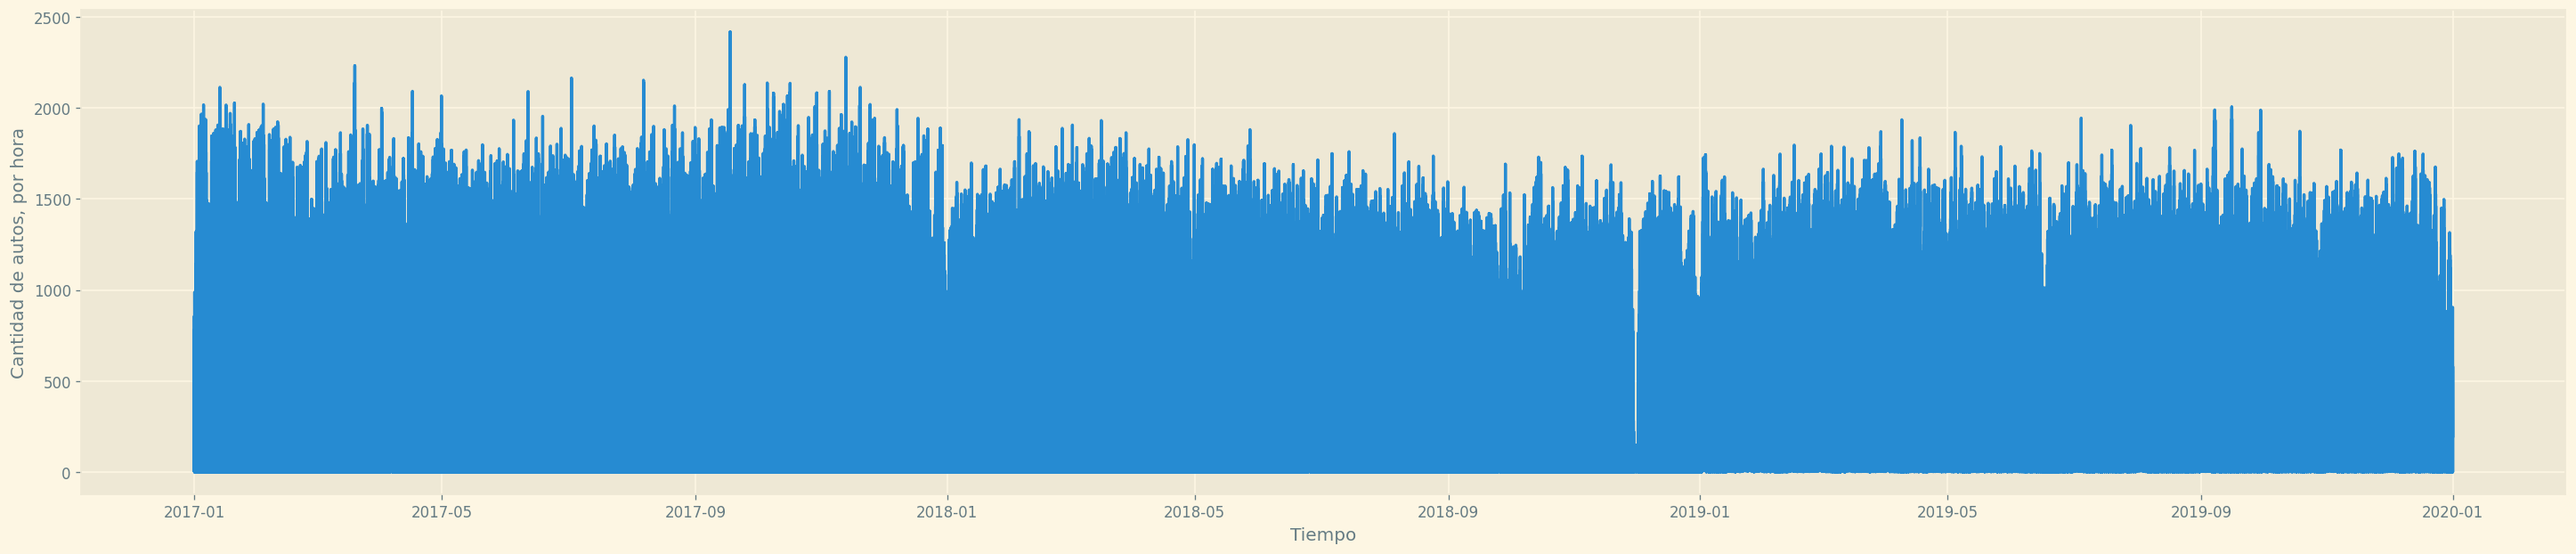

In [339]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (30,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [340]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

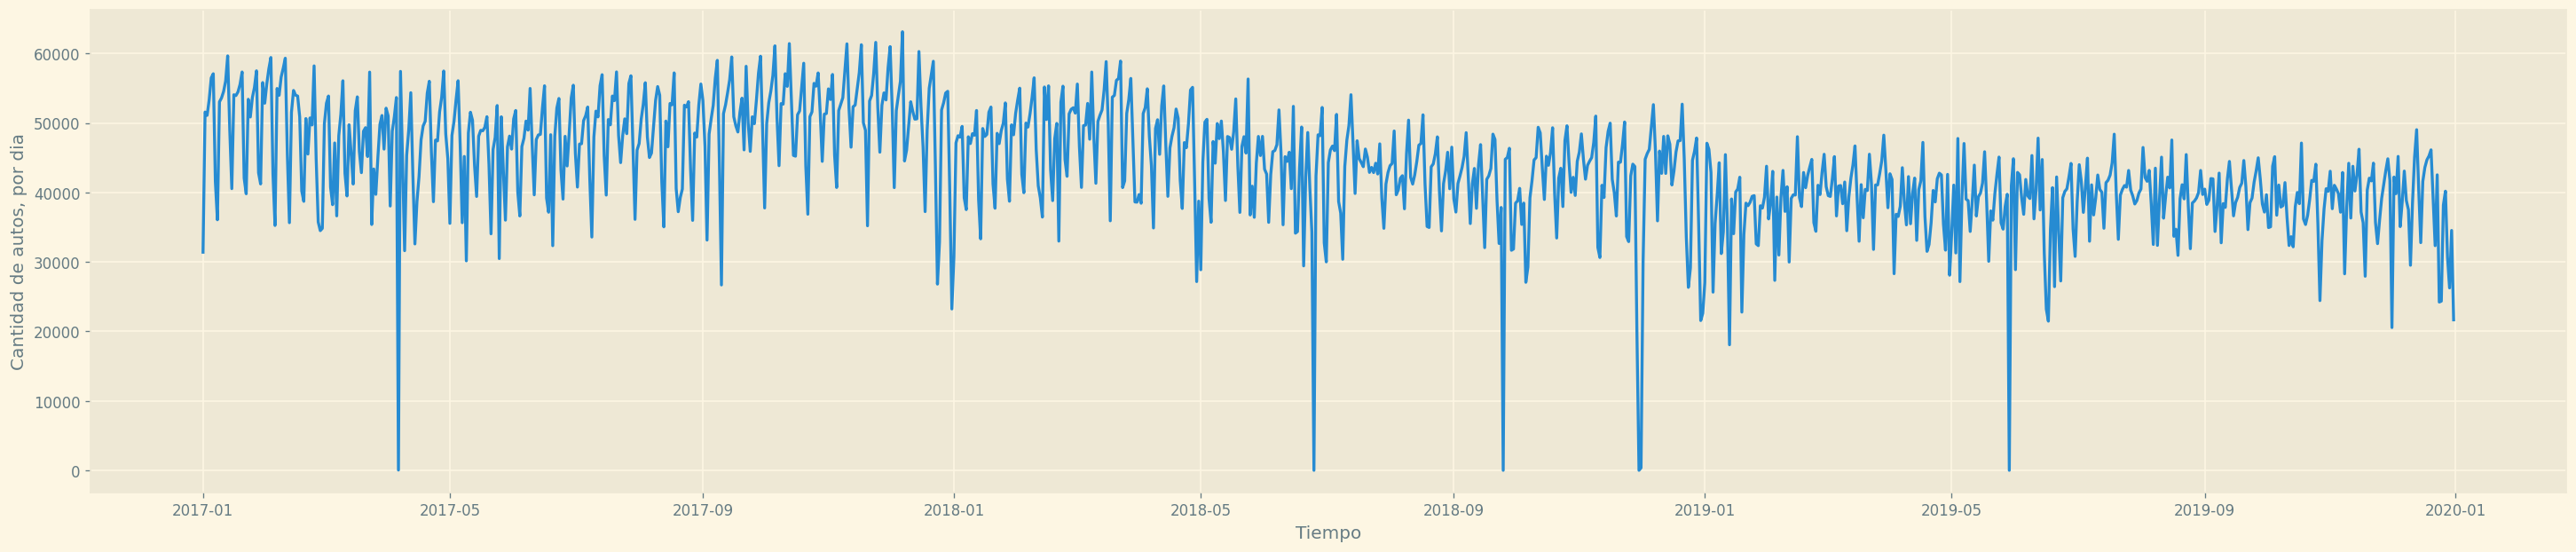

In [341]:
plt.figure(figsize = (30,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [342]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
hora = dataset.resample('H', on = 'fecha').sum()
print(hora.shape)
hora.head()

(26280, 1)


cantidad_pasos
fecha                              
2017-01-01 00:00:00            1576
2017-01-01 01:00:00               1
2017-01-01 02:00:00            1374
2017-01-01 03:00:00            1734
2017-01-01 04:00:00            1247

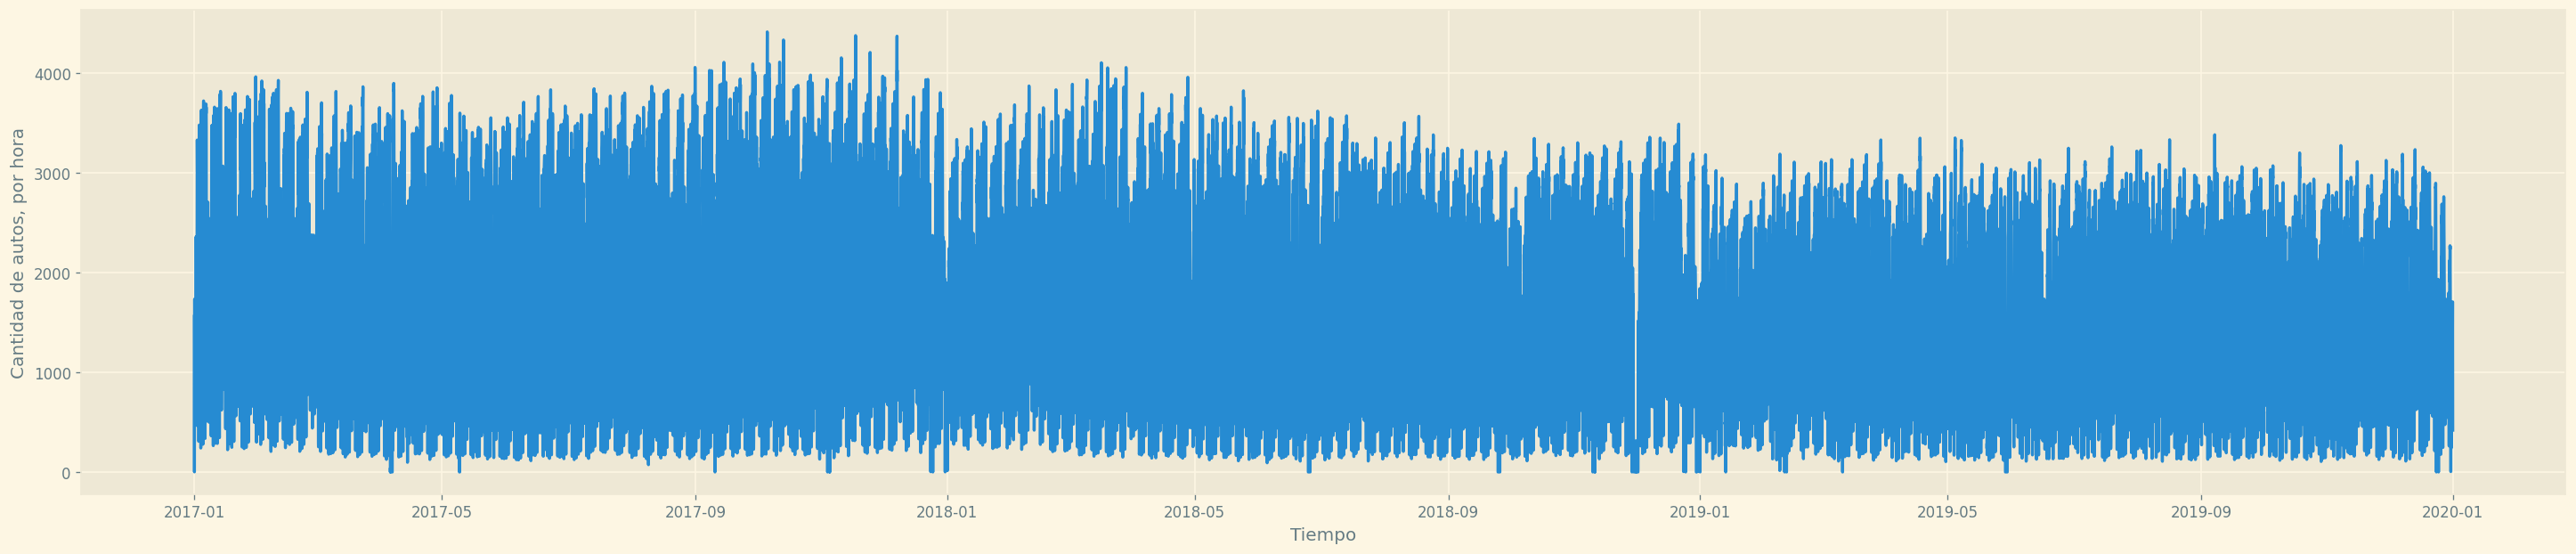

In [343]:
plt.figure(figsize = (30,6))
plt.plot(hora.index, hora.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

---

<br />
<br />

# ANÁLISIS EXPLORATORIO DE DATOS
<br />
<br />

---

## Datasets

Se tiene 4 datasets, uno por cada año, más el dataset que agrupa los tres años filtrado por estación y por tipo depago.

In [344]:
print('Shape 2017: ', data_2017.shape)
print('Shape 2018: ', data_2018.shape)
print('Shape 2019: ', data_2019.shape)
print('Shape Total (Illia / Efectivo): ', dataset.shape)

Shape 2017:  (1372645, 10)
Shape 2018:  (1375908, 10)
Shape 2019:  (812153, 10)
Shape Total (Illia / Efectivo):  (238869, 5)


###  Dataset

**Consideremos el dataset completo para realizar el EDA**

In [345]:
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
1       Domingo  Provincia       Liviano               9 2017-01-01 00:00:00
2       Domingo  Provincia       Liviano             644 2017-01-01 00:00:00
3       Domingo  Provincia        Pesado               6 2017-01-01 00:00:00
4       Domingo  Provincia        Pesado               1 2017-01-01 00:00:00
...         ...        ...           ...             ...                 ...
238864   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
238865   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
238866   Martes     Centro       Liviano             580 2019-12-31 22:00:00
238867   Martes     Centro       Liviano             214 2019-12-31 23:00:00
238868   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[238869 rows x 5 columns]

In [346]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238869 entries, 0 to 238868
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   dia             238869 non-null  object        
 1   sentido         238869 non-null  object        
 2   tipo_vehiculo   238869 non-null  object        
 3   cantidad_pasos  238869 non-null  int64         
 4   fecha           238869 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.1+ MB


El dataset sobre el que se aplicará el trabajo es una concatenación de los datasets de los años 2017/ '18 y '19.


## Valores Unicos

In [347]:
unique = dataset.nunique()
unique

dia                   7
sentido               2
tipo_vehiculo         2
cantidad_pasos     1967
fecha             26102
dtype: int64

In [348]:
dataset['dia'].unique()

array(['Domingo', 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes',
       'Sábado'], dtype=object)

La columna 'dia' contiene todos los días de la semana.

In [349]:
dataset['sentido'].unique()

array(['Provincia', 'Centro'], dtype=object)

Existen dos unicos sentidos, Provincia y Centro

In [350]:
dataset['tipo_vehiculo'].unique()

array(['Pesado', 'Liviano'], dtype=object)

Existen dos tipos de vehiculos: Liviano y Pesado


No tiene sentido revisar valores unicos de pases y fecha, ya que se esperan tener muchos valores de estos items.

## Valores Nulos

In [351]:
def null_det(df):
    df_nulo = df.isnull().sum().sort_values(ascending =False)[df.isnull().sum()>0]
    df_nulo = pd.DataFrame({'Nombre_de_columna_con_Nulos':df_nulo.index,'Cant_de_Nulos':df_nulo.values})
    df_nulo['% de Nulos'] = round(((df_nulo.Cant_de_Nulos/df.shape[0])*100),2)
    return(df_nulo)

In [352]:
null_det(dataset)

Empty DataFrame
Columns: [Nombre_de_columna_con_Nulos, Cant_de_Nulos, % de Nulos]
Index: []

A continuación se explora en detalle cada dataset original en busca de nulos:

In [353]:
null_det(data_2017)

Empty DataFrame
Columns: [Nombre_de_columna_con_Nulos, Cant_de_Nulos, % de Nulos]
Index: []

In [354]:
null_det(data_2018)

Empty DataFrame
Columns: [Nombre_de_columna_con_Nulos, Cant_de_Nulos, % de Nulos]
Index: []

In [355]:
null_det(data_2019)

Empty DataFrame
Columns: [Nombre_de_columna_con_Nulos, Cant_de_Nulos, % de Nulos]
Index: []

No se encontraron nulos en los datasets originales.

## Outliers

Para reducir la variabilidad del número de pases, estos se agrupan por día:

In [356]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486

In [357]:
diario.describe()

cantidad_pasos
count     1095.000000
mean     43712.859361
std       8192.736927
min          0.000000
25%      39061.500000
50%      43761.000000
75%      49498.000000
max      63127.000000

Text(0.5, 1.0, 'Pasos por Día')

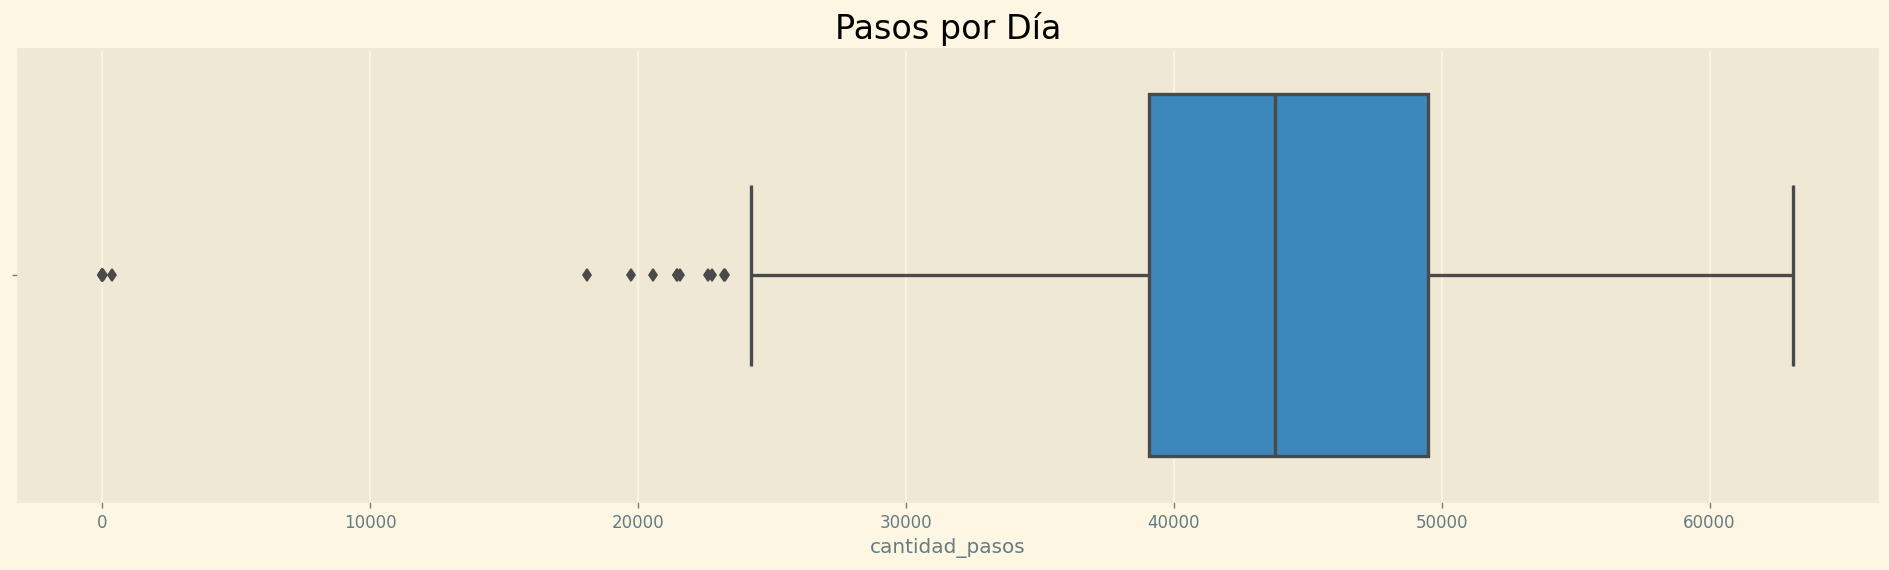

In [358]:
plt.figure(figsize=(20,5))
sns.boxplot(diario.cantidad_pasos)
plt.title("Pasos por Día", fontsize=20)

Graficamente se obervan algunos valores por debajo del outlier inferior.\
Determinemos el outlier inferior y cuanto representan estos en la data.

In [359]:
Q1 = diario['cantidad_pasos'].quantile(0.25)
Q2 = diario['cantidad_pasos'].quantile(0.50)
Q3 = diario['cantidad_pasos'].quantile(0.75)


IQR = Q3 - Q1

low_lim = Q1 - 1.5 * IQR
up_lim = Q3 + 1.5 * IQR
low_lim

23406.75

Se tiene como outlier inferior el valor de 23406 pasos

In [360]:
menores_que_outlier = diario.loc[diario['cantidad_pasos']<low_lim]
porcentaje_menores_que_outlier = 100*menores_que_outlier.count()/diario.count()
print('Porcentaje de pases menores al Outlier: ', porcentaje_menores_que_outlier) 

Porcentaje de pases menores al Outlier:  cantidad_pasos    1.461187
dtype: float64


In [361]:
menores_que_outlier

cantidad_pasos
fecha                     
2017-04-06              40
2017-12-31           23229
2018-06-25               0
2018-09-25               0
2018-11-29           19728
2018-11-30               0
2018-12-01             350
2018-12-30           21559
2018-12-31           22599
2019-01-13           18076
2019-01-19           22774
2019-05-29               0
2019-06-16           23190
2019-06-17           21469
2019-12-01           20553
2019-12-31           21447

Los días con cero pases desentonan al compararlos con el resto de outliers.
Al explorar el motivo se encuentra lo siguiente:

* 2017-04-06: Huelga General
* 2018-06-25: Huelga General
* 2018-09-25: Huelga General
* 2018-11-30: Reunión G20
* 2018-12-01: Reunión G20 
* 2019-05-29:  Huelga General

## DataSet Diario

En adelante se toma el dataset sin outliers, tal como se obsreva en filtrado siguiente:

In [362]:
diario = diario[diario.cantidad_pasos > low_lim]
diario

cantidad_pasos
fecha                     
2017-01-01           31183
2017-01-02           51568
2017-01-03           51093
2017-01-04           53332
2017-01-05           56486
...                    ...
2019-12-26           38168
2019-12-27           40182
2019-12-28           30681
2019-12-29           26259
2019-12-30           34523

[1079 rows x 1 columns]

## Distribuciones

Para el analizis de las distribuciones tenemos que trabajar con los datasets de cada año. Esto para poder ver en mejor detalle la distribución de cada item.

Enfoquemonos en:\
-Estacion (categórica)\
-Sentido (categórica)\
-Tipo de Vehiculo (categórica)\
-Forma de Pago (categórica)
-Cantidad de Pases (numérica)

### Categóricas

In [363]:
def plot_cat(cat, y_lim):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.countplot(data_2017[cat])
    plt.title(f'Distribución de {cat} del Año 2017', size=13, fontweight='bold')
    plt.xticks(rotation=90, size=10)
    plt.ylim(0,y_lim)
    plt.subplot(1,3,2)
    sns.countplot(data_2018[cat])
    plt.title(f'Distribución de {cat} del Año 2018', size=13, fontweight='bold')
    plt.xticks(rotation=90, size=10)
    plt.ylim(0,y_lim)
    plt.subplot(1,3,3)
    sns.countplot(data_2019[cat])
    plt.title(f'Distribución de {cat} del Año 2019', size=13, fontweight='bold')
    plt.xticks(rotation=90, size=10)
    plt.ylim(0,y_lim)
    plt.tight_layout()

**Estación**

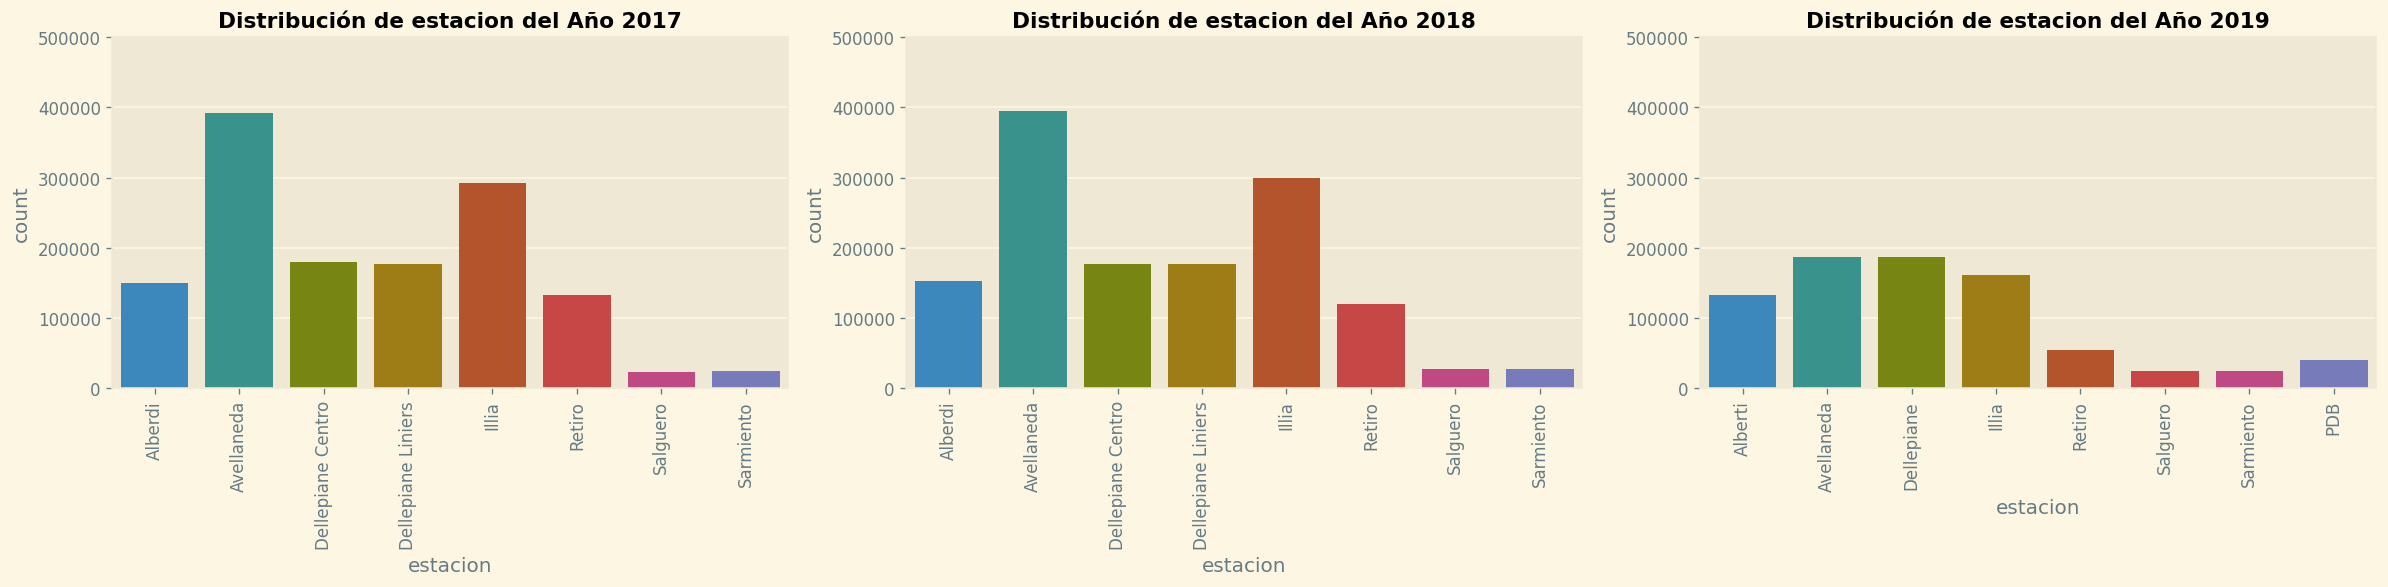

In [364]:
plot_cat('estacion', 500000)

Se aprecia un patrón similar para los datasets de 2017 y '18, donde la estación Avellaneda resulta la de mayores pases.

Por otro lado, para el año 2019 se observa otra distribución de pases en función de las estaciones, con valores de pases considerablemente menores, sobre todo para las estaciones Avellaneda e Illia

**Sentido**

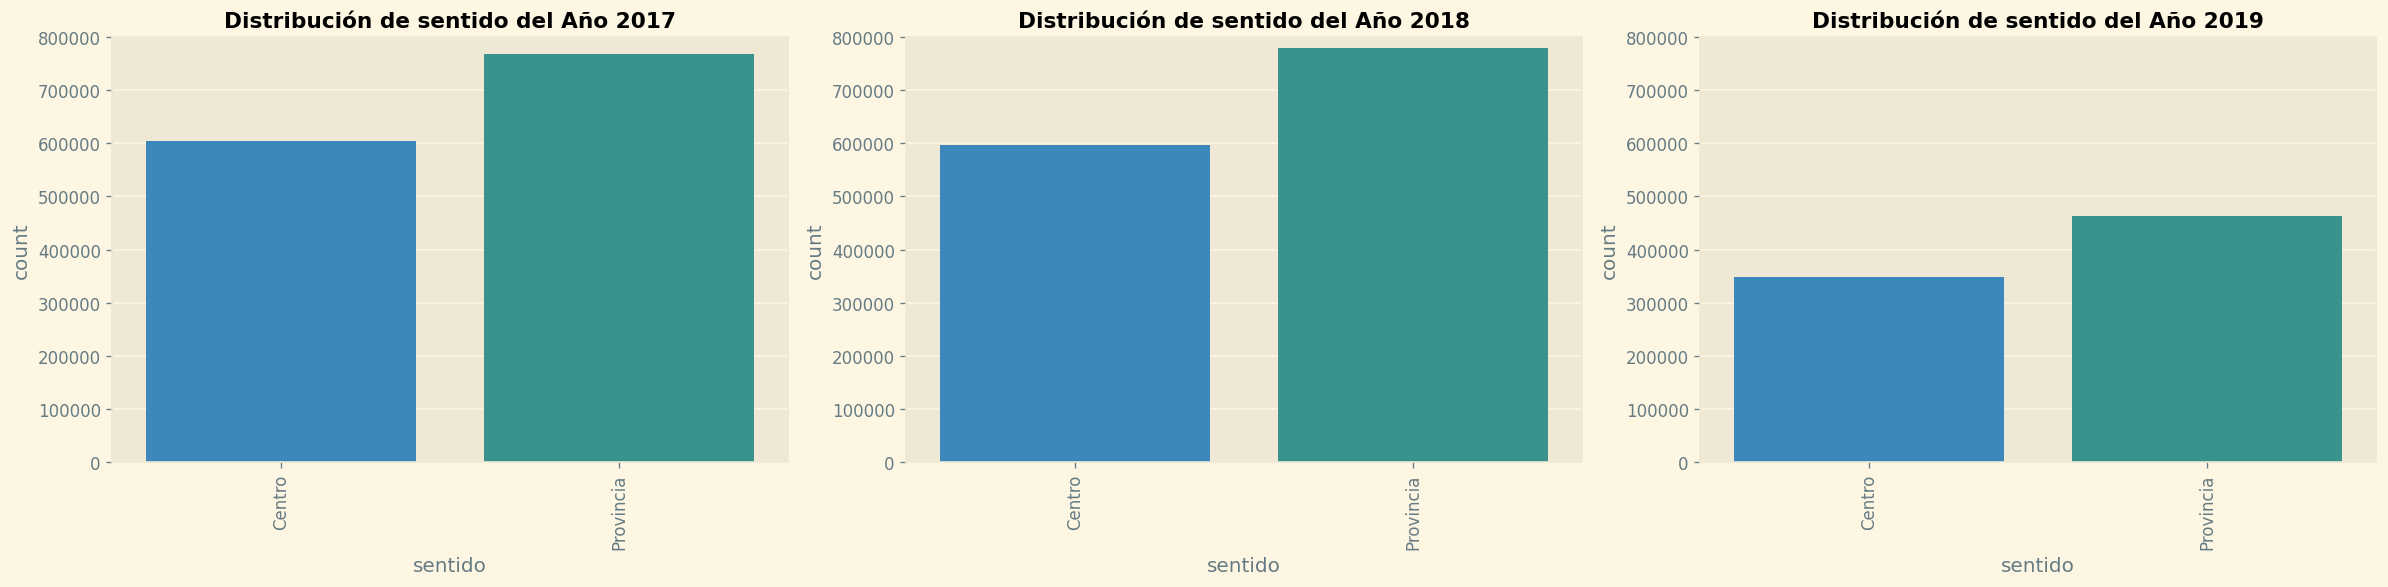

In [365]:
plot_cat('sentido', 800000)

Para el caso del sentido de circulación de los pases contabilizados, vemos un patrón muy similar para 2017 y '18. 2019 no se muestra tan diferente en terminos relativos, reflejando una menor cantidad de pases, consistentemente con lo observado en el grupo de gráficos anteriores.

**Tipo de Vehículo**

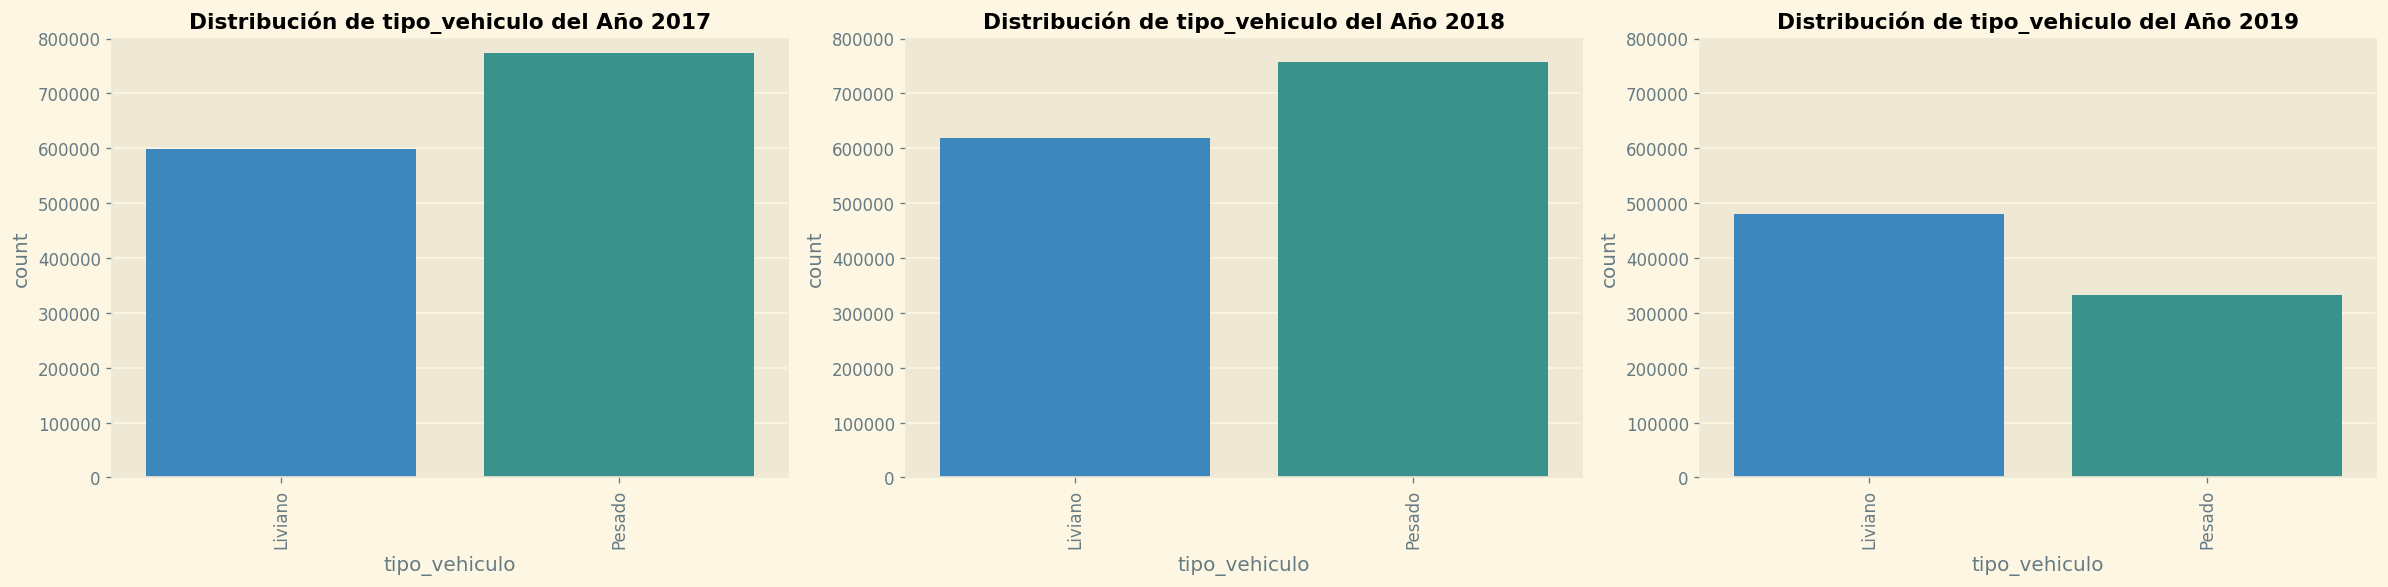

In [366]:
plot_cat('tipo_vehiculo', 800000)

Por tipo de vehículo, vemos que la distribución es prácticamente un reflejo de aquella para el sentido de circulación, para los casos de 2017 y '18, a excepción de la distribución para 2019.

**Forma de Pago**

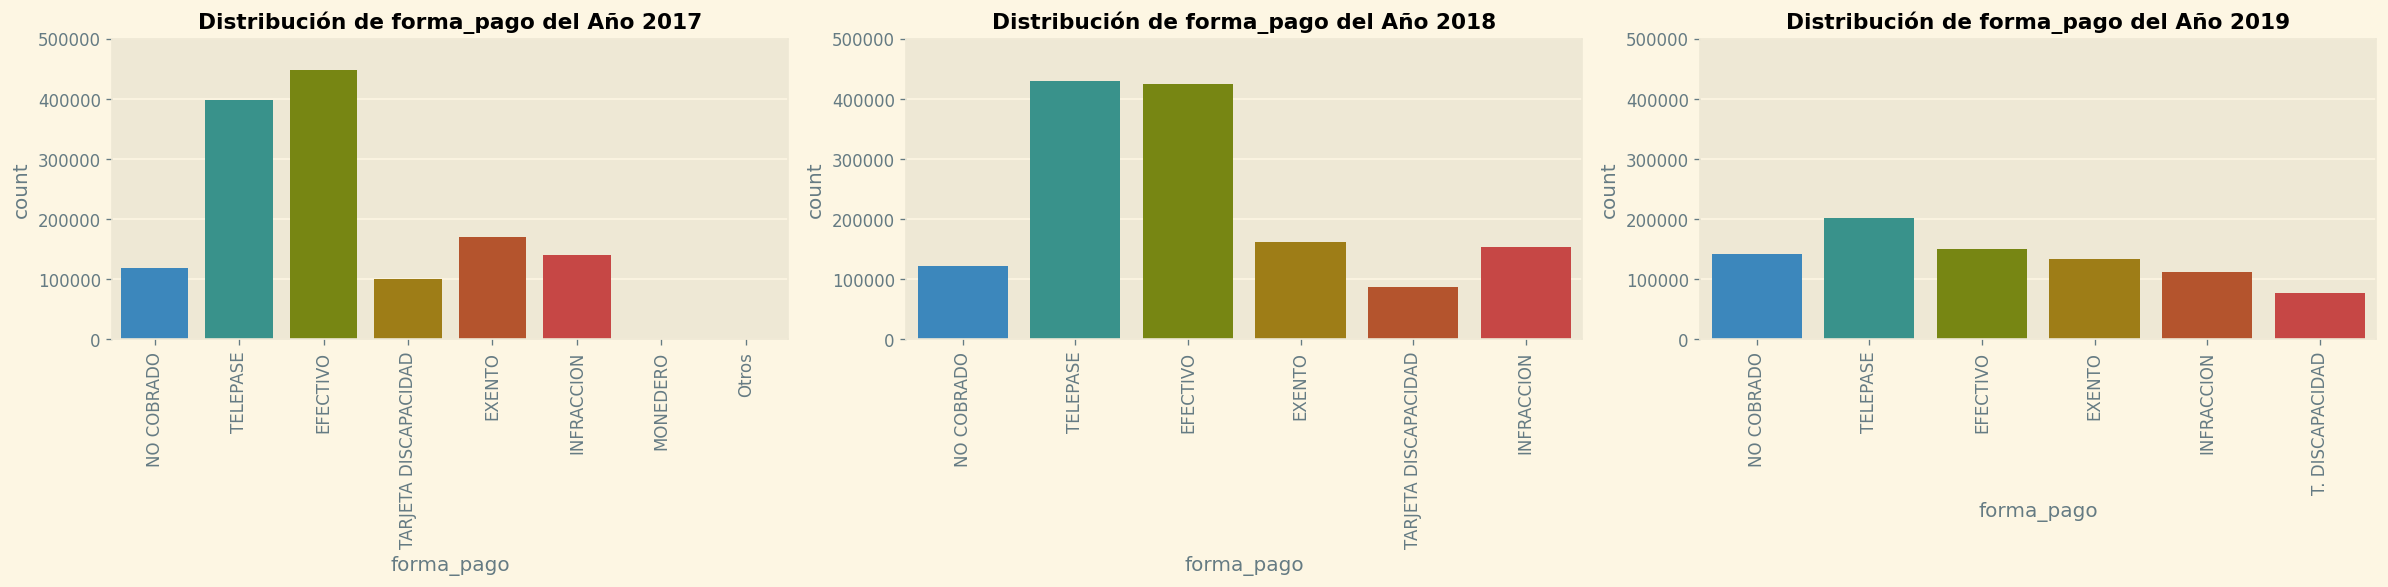

In [367]:
plot_cat('forma_pago', 500000)

Similar a lo comentado anteriormente, en este caso se observa similares distribuciones de forma de pago de los pases para 2017 y '18, arrojando valores máximos para los modos TELEPASE y EFECTIVO. Para el año 2019 vemos notablemente menor cantidad de pases, predominando también las mismas formas de pago que para 2017 y '18.

### Numéricas

**Cantidad de Pasos**\
Es de interés en este caso, apreciar la distribución de las cantidades de pasos para cada año:

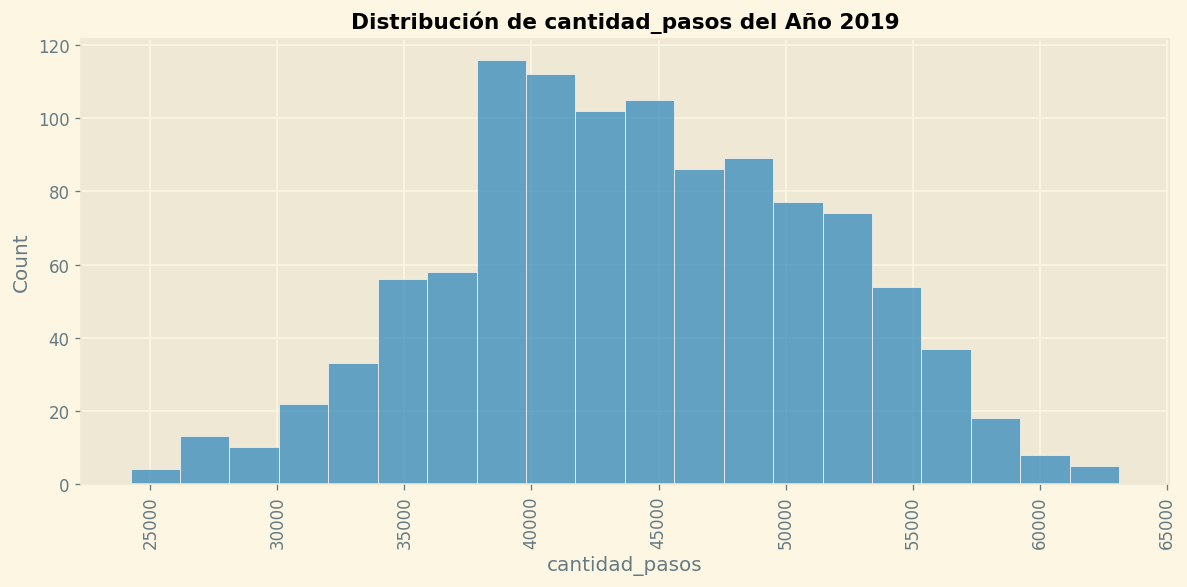

In [368]:
plt.figure(figsize=(10,5))

cat = 'cantidad_pasos'
sns.histplot(diario[cat])
plt.title(f'Distribución de {cat} del Año 2019', size=13, fontweight='bold')
plt.xticks(rotation=90, size=10)
plt.tight_layout()

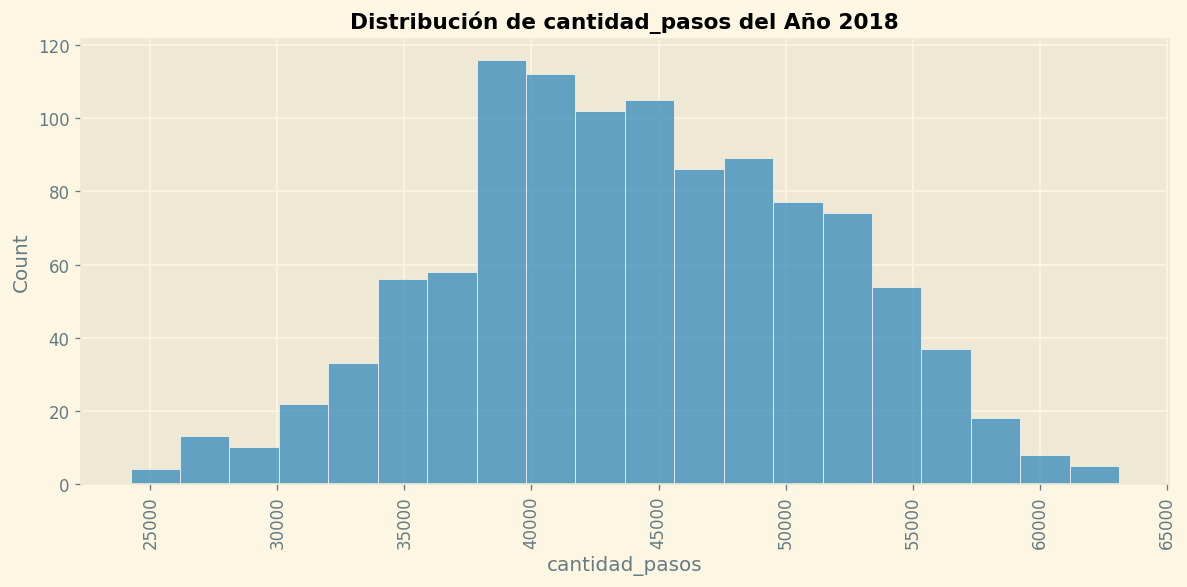

In [369]:
plt.figure(figsize=(10,5))

cat = 'cantidad_pasos'
sns.histplot(diario[cat])
plt.title(f'Distribución de {cat} del Año 2018', size=13, fontweight='bold')
plt.xticks(rotation=90, size=10)
plt.tight_layout()

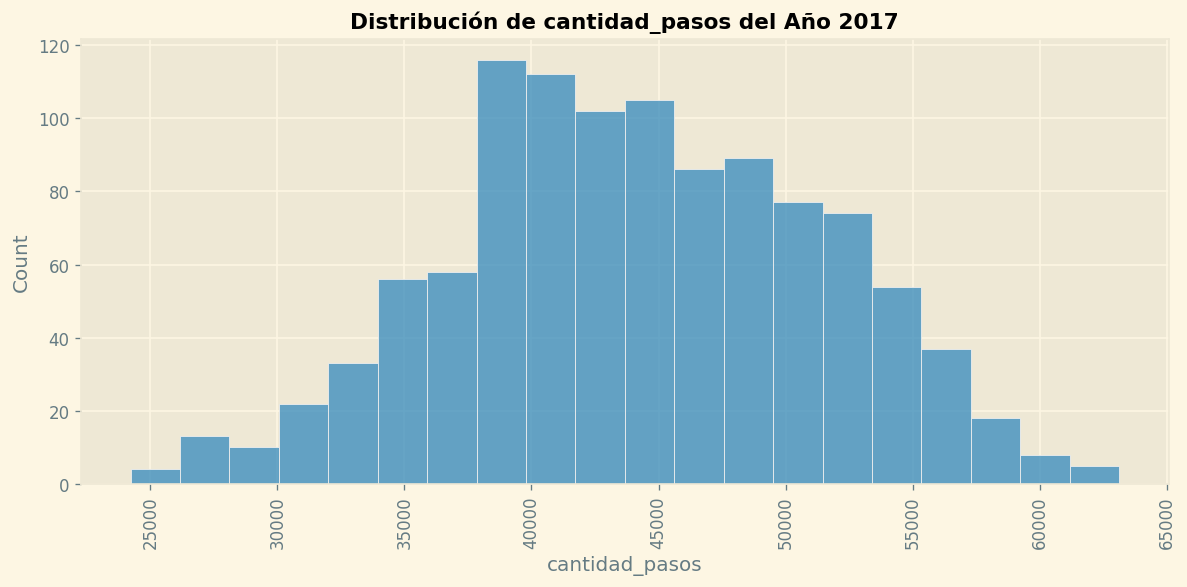

In [370]:
plt.figure(figsize=(10,5))

cat = 'cantidad_pasos'
sns.histplot(diario[cat])
plt.title(f'Distribución de {cat} del Año 2017', size=13, fontweight='bold')
plt.xticks(rotation=90, size=10)
plt.tight_layout()

Observamos una distribución un tanto sesgada a la derecha, para los 3 periodos evaluados.

## Descomposición de la serie

Al trabajar con series de tiempo, existen parámetros típicos que se pueden desglosar de los datos, tal como lo hace la función, Seasonal_decompose:
    - Trend (Tendencia)\
    - Seasonality (Estacionalidad)\
    - Residual/Noise (Ruido)

El método Seasonal Decompose posee dos modelos disponibles, uno de adición y otro multiplicativo.

Vamos a asumir modelo de adición y visualizar los parámetros o componentes:

<Figure size 1200x1200 with 0 Axes>

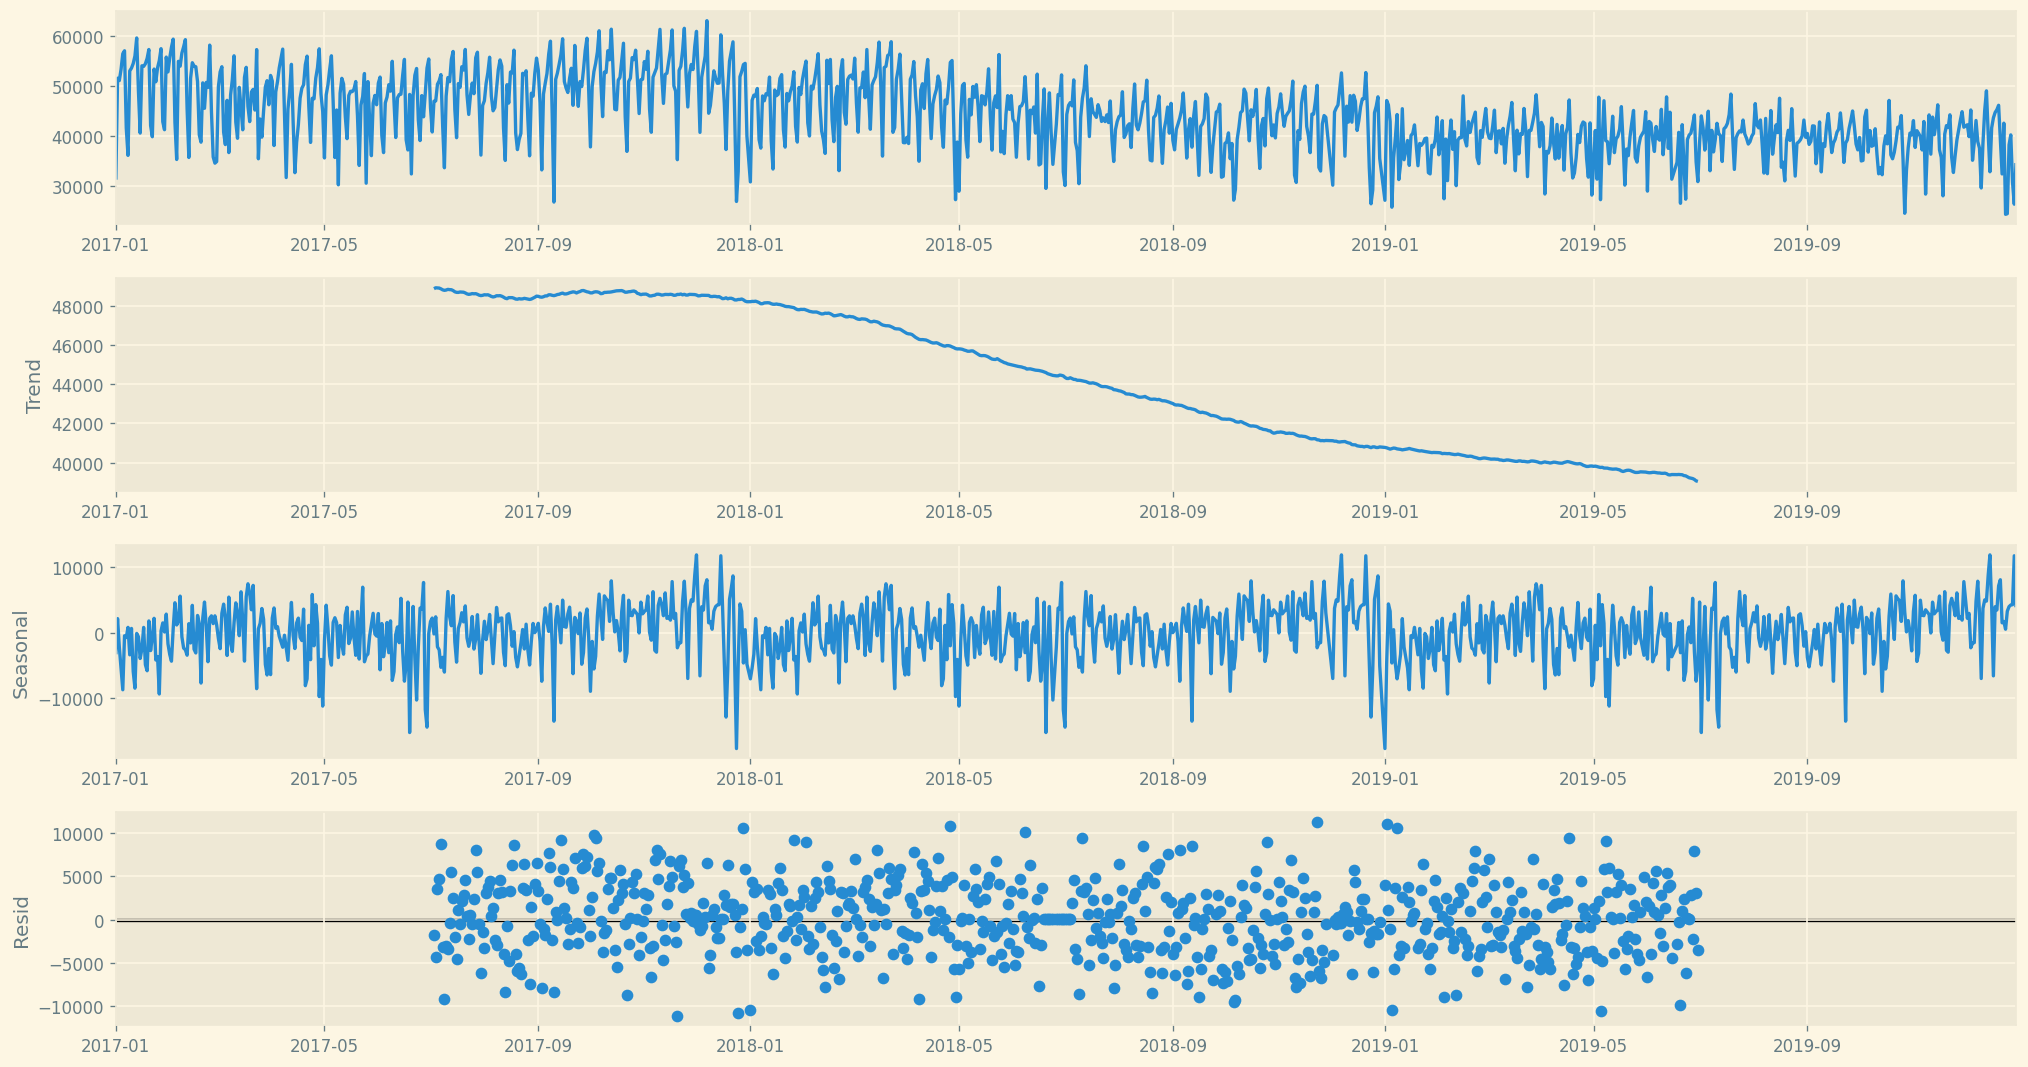

In [371]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,10))
result = seasonal_decompose(diario, model='additive', freq=365)
fig = result.plot()
fig.set_size_inches((17, 9))
fig.tight_layout()
plt.show()

Ahora modelo multiplicativo:

<Figure size 1200x1200 with 0 Axes>

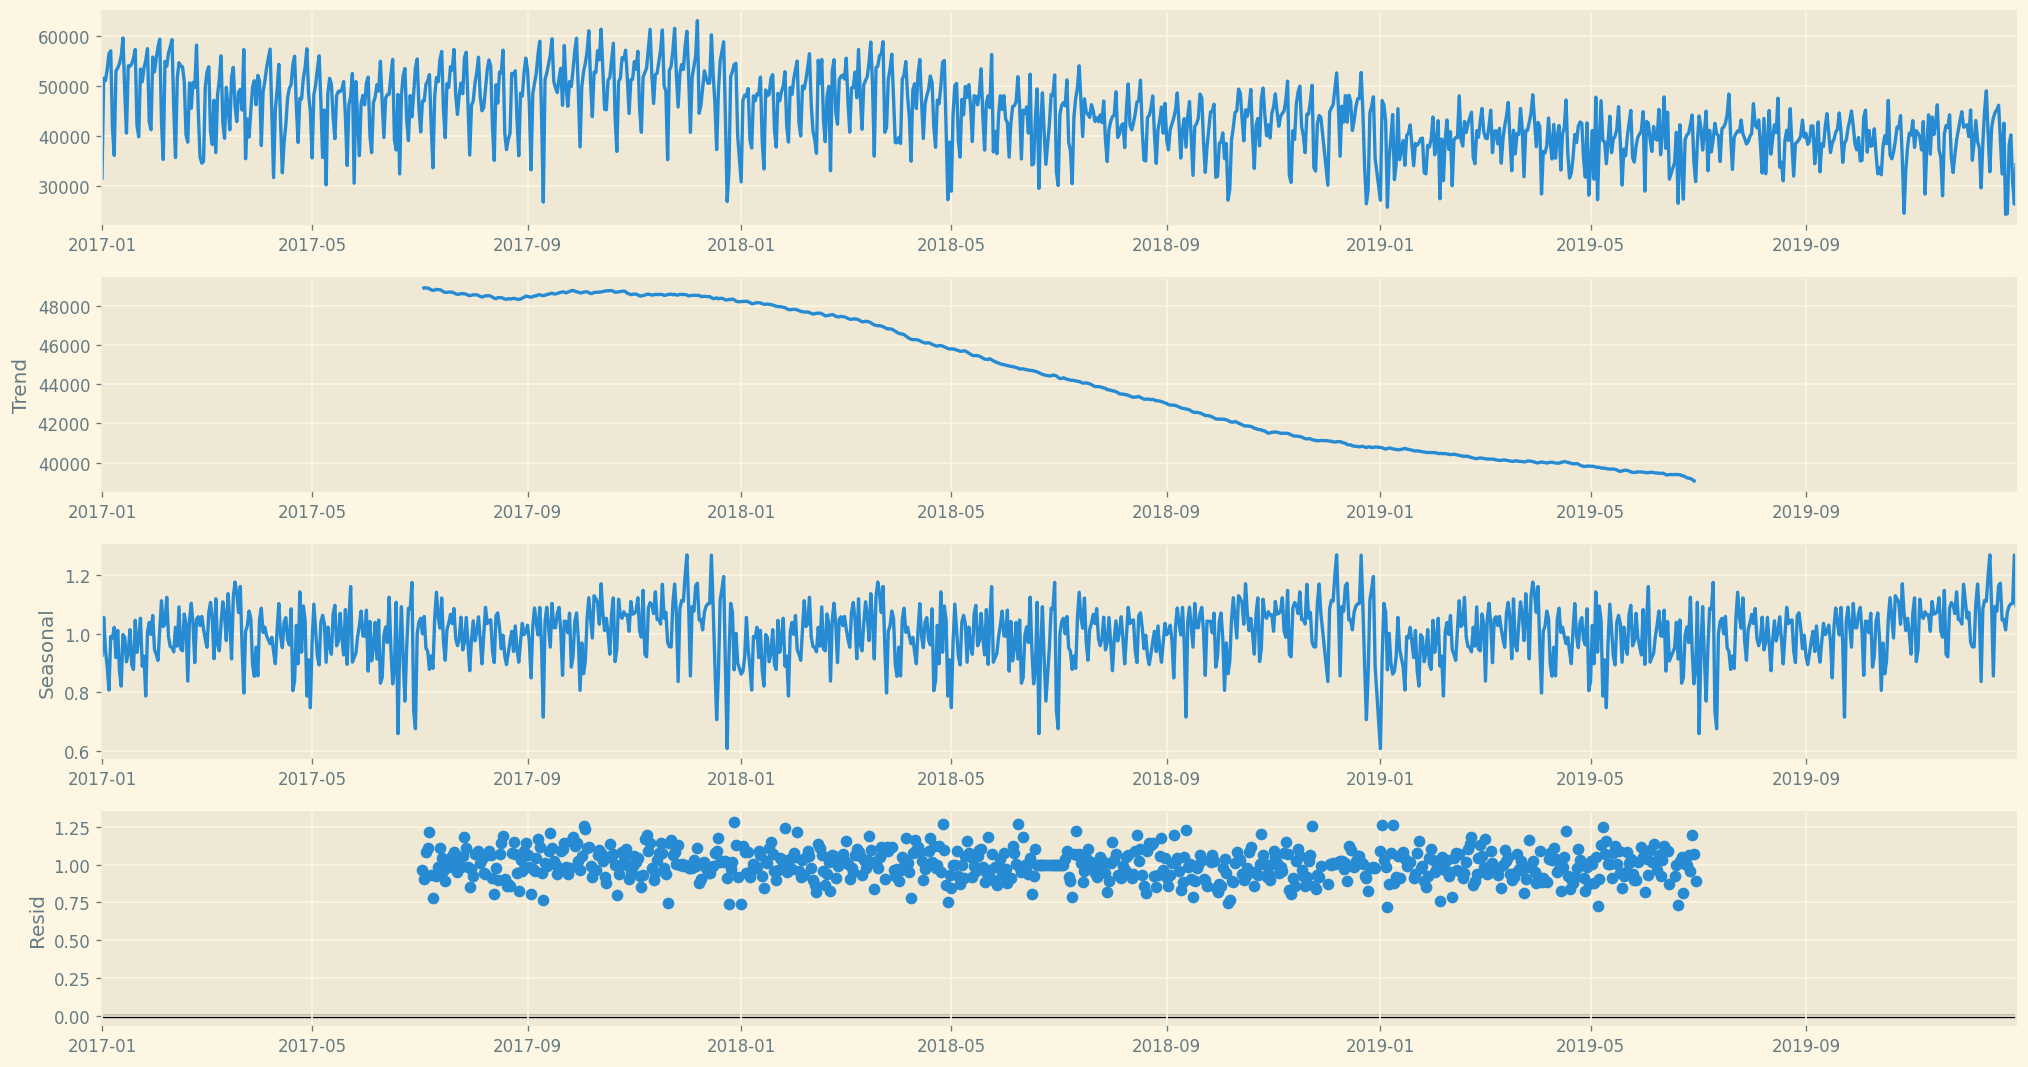

In [372]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(10,10))
result = seasonal_decompose(diario, model='multiplicative', freq=365)
fig = result.plot()
fig.set_size_inches((17, 9))
fig.tight_layout()
plt.show()

En ambos casos se oberva una tendencia a disminuir en el tiempo con cierta estabilización al inicio y al final.

Por lo general las tendencias exponenciales responden a modelos multiplicativos, y tendencias con cierta linealidad a modelos de adición, a continuación probemos un modelo de adición pero considerando frecuencia semanal: 

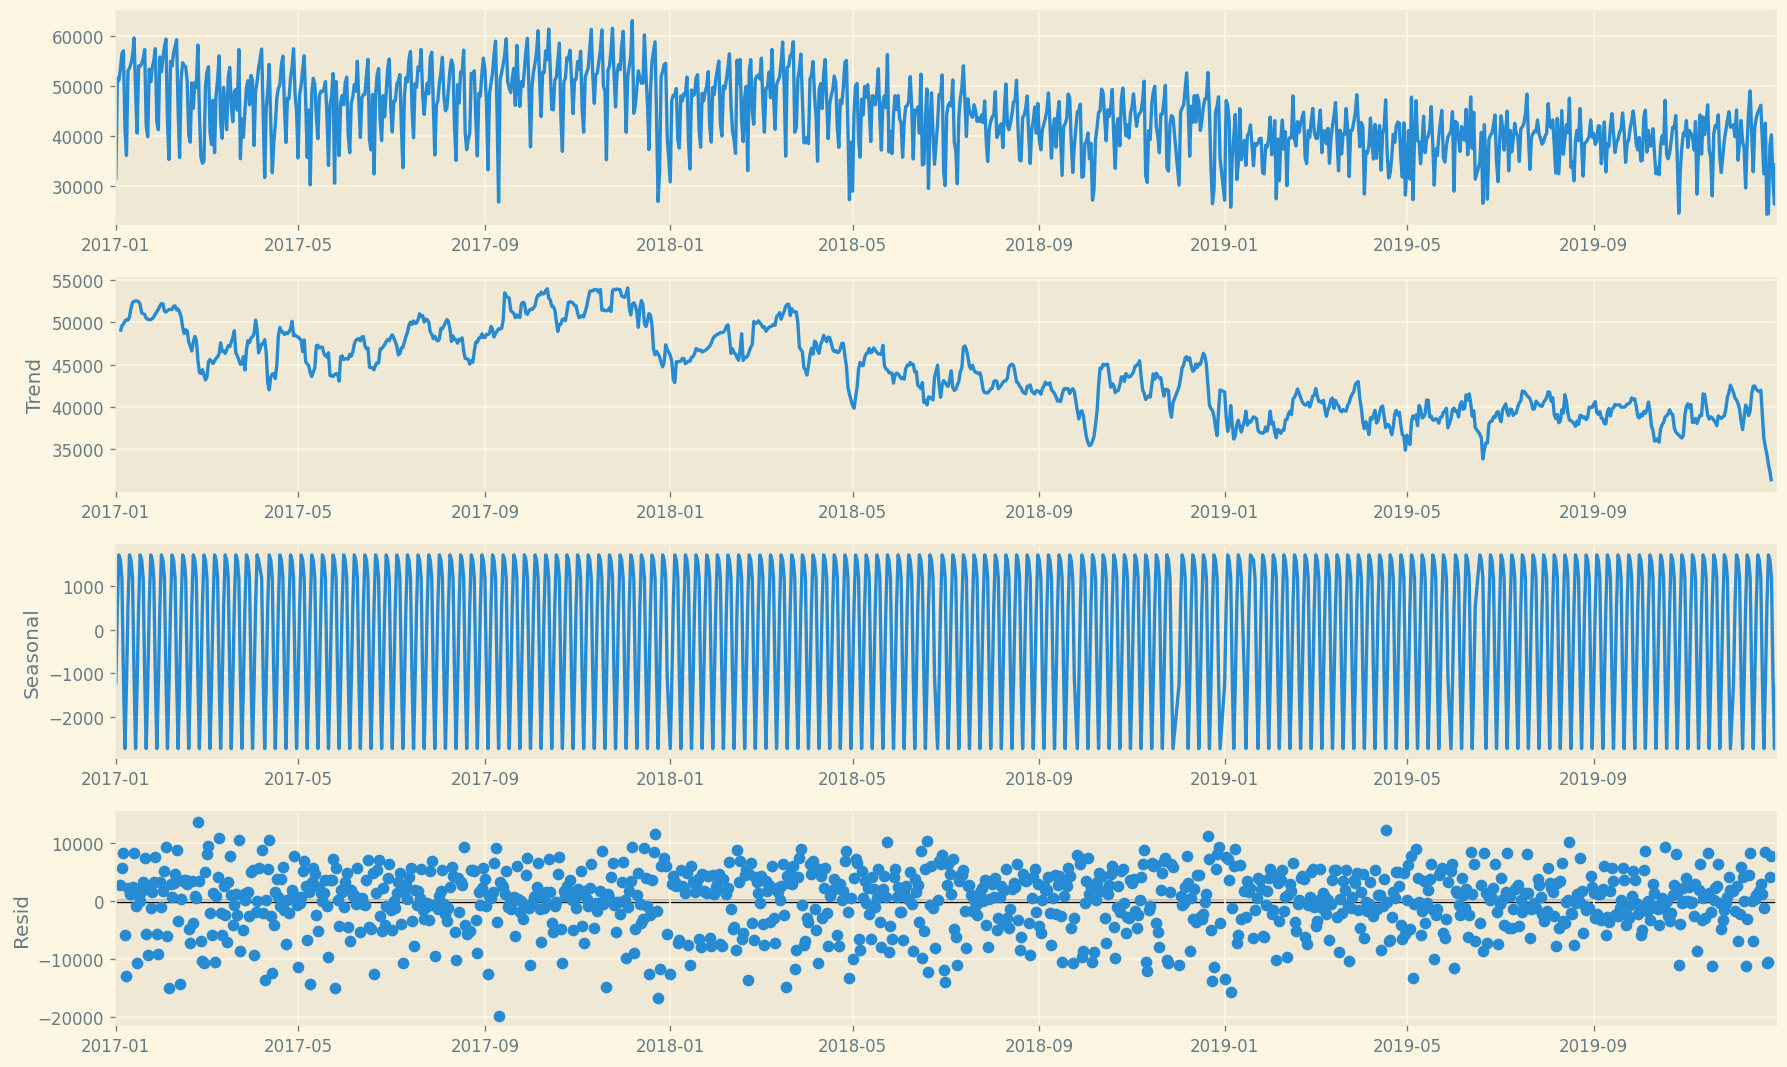

In [373]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(diario, model='additive', freq=7)
fig = result.plot()
fig.set_size_inches((15, 9))
fig.tight_layout()
plt.show()

Se aprecia una periodicidad muy marcada en el parámetro de estacionalidad, ya que los ciclos semanales se espera tengan una alta repetitividad (todos los Lunes hay muchos más pases que un Domingo, y así...)

In [374]:
import statsmodels.api as sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


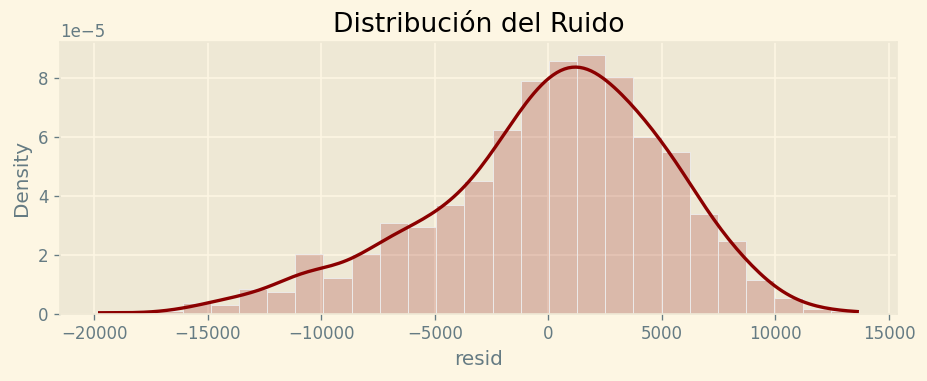

In [375]:
!pip install statsmodels
import statsmodels.api as sm
descomposicion_diario = sm.tsa.seasonal_decompose(diario['cantidad_pasos'], model='additive', freq=7)
residual_diario = descomposicion_diario.resid

# plt.figure(figsize = (6,4))
fig = sns.histplot(data=residual_diario, stat='density', kde=True, color='darkred', alpha=0.2)
plt.title('Distribución del Ruido', fontsize=16)
plt.show()


El ruido en una serie de tiempo está integrado por aquellos valores o datos que no caen dentro de la tendencia y estacionalidad que considera el método utilizado.
En la figura anterior se observa la distribución de este ruido o residuo.

## Prueba de ADFuller

In [376]:
result  = adfuller(diario.cantidad_pasos)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[2]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.7085053152896066
n_lags: 22
p-value: 0.426735696453571
Critial Values:
   1%, -3.436557639266102
Critial Values:
   5%, -2.8642808573632874
Critial Values:
   10%, -2.5682293371570823


El resultado obtenido de p-value es mayor que el nivel de significancia de 0.05 y el ADF Statistic es mayor que cualquier valor critico.\
Claramente no hay razon para rechazar  la hipotesis nula. Por lo que la serie es de hecho No-Stacionaria

# MODELOS DE MACHINE LEARNING

## Separación Train/Test

Se hace una consideración del fenómeno mediante la disposición de los datos agrupados por día y por semana.

Preparando dataset diario, aseguremonos de tener una columna de fecha en numero para ser utlizada mas adelante.

In [377]:
diario = dataset[["fecha","cantidad_pasos"]].resample('D', on = 'fecha').sum()
diario["fecha_num"] = diario.index.map(datetime.datetime.toordinal)
diario.head(2).append(diario.tail(2))

cantidad_pasos  fecha_num
fecha                                
2017-01-01           31183     736330
2017-01-02           51568     736331
2019-12-30           34523     737423
2019-12-31           21447     737424

Dataset semanal:

In [378]:
# El periodo a predecir es el ultimo trimestre del 2019, es decir desde el 1/10/2019

diario.reset_index("fecha",inplace=True)


semanal = diario.copy()
semanal.reset_index(inplace=True)
semanal.drop(columns=['fecha_num'], inplace=True)

# semanal.reset_index('fecha', inplace=True)
diario.set_index("fecha", inplace=True)

In [379]:
semanal = semanal[["fecha","cantidad_pasos"]].resample('W', on = 'fecha').sum()
semanal["fecha_num"] = semanal.index.map(datetime.datetime.toordinal)
semanal.head(3).append(semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-01           31183     736330
2017-01-08          347212     736337
2017-01-15          366413     736344
2019-12-22          292881     737415
2019-12-29          226390     737422
2020-01-05           55970     737429

In [380]:
semanal.drop(semanal.tail(1).index,inplace=True)
semanal.drop(semanal.head(1).index,inplace=True)
semanal.head(3).append(semanal.tail(3))

cantidad_pasos  fecha_num
fecha                                
2017-01-08          347212     736337
2017-01-15          366413     736344
2017-01-22          357215     736351
2019-12-15          272960     737408
2019-12-22          292881     737415
2019-12-29          226390     737422

Separamos los últimos tres meses para dejarlos como test:

In [381]:
diario.reset_index("fecha",inplace=True)
semanal.reset_index("fecha",inplace=True)

train_diario = diario.loc[(diario['fecha'] < '2019-10-01')]
test_diario = diario.loc[(diario['fecha'] >= '2019-10-01')]

train_semanal = semanal.loc[(semanal['fecha'] < '2019-10-01')]
test_semanal = semanal.loc[(semanal['fecha'] >= '2019-10-01')]

diario.set_index("fecha", inplace=True)
train_diario.set_index("fecha", inplace=True)
test_diario.set_index("fecha", inplace=True)


semanal.set_index("fecha", inplace=True)
train_semanal.set_index("fecha", inplace=True)
test_semanal.set_index("fecha", inplace=True)

In [382]:
train_diario

cantidad_pasos  fecha_num
fecha                                
2017-01-01           31183     736330
2017-01-02           51568     736331
2017-01-03           51093     736332
2017-01-04           53332     736333
2017-01-05           56486     736334
...                    ...        ...
2019-09-26           43110     737328
2019-09-27           44985     737329
2019-09-28           41925     737330
2019-09-29           38348     737331
2019-09-30           37170     737332

[1003 rows x 2 columns]

In [383]:
test_diario

cantidad_pasos  fecha_num
fecha                                
2019-10-01           39669     737333
2019-10-02           34943     737334
2019-10-03           35054     737335
2019-10-04           43775     737336
2019-10-05           45150     737337
...                    ...        ...
2019-12-27           40182     737420
2019-12-28           30681     737421
2019-12-29           26259     737422
2019-12-30           34523     737423
2019-12-31           21447     737424

[92 rows x 2 columns]

In [384]:
train_semanal

cantidad_pasos  fecha_num
fecha                                
2017-01-08          347212     736337
2017-01-15          366413     736344
2017-01-22          357215     736351
2017-01-29          354581     736358
2017-02-05          359401     736365
...                    ...        ...
2019-09-01          279775     737303
2019-09-08          276271     737310
2019-09-15          272592     737317
2019-09-22          279927     737324
2019-09-29          287568     737331

[143 rows x 2 columns]

In [385]:
test_semanal

cantidad_pasos  fecha_num
fecha                                
2019-10-06          272483     737338
2019-10-13          260840     737345
2019-10-20          267147     737352
2019-10-27          262950     737359
2019-11-03          273129     737366
2019-11-10          270536     737373
2019-11-17          281790     737380
2019-11-24          264500     737387
2019-12-01          266555     737394
2019-12-08          282891     737401
2019-12-15          272960     737408
2019-12-22          292881     737415
2019-12-29          226390     737422

## Arima (Benchmark)

Antes de inciar a trabajar en los modelos de Machine Learning, definamos un par de funciones que nos ayudarán al dedsarrollo de los mismos:

In [386]:
def evaluar_modelo(y_pred, y_true, model):

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    dataf = pd.DataFrame({
        "Modelo": model,
        "RMSE":[RMSE]
    })
    return dataf

def plot_modelo(train,test,pred) :
    fig, (ax1,ax2) = plt.subplots(2,figsize=(18,8))

    ax1.plot(train, label='Train')
    ax1.plot(test , label='Test')
    ax1.plot(pred, label='Forecast')
    ax1.legend(loc="upper right")
    ax1.grid(axis = "both")
    ax2.plot(test, label='Test')
    ax2.plot(pred, label='Forecast')
    ax2.legend(loc="upper right")

    fig.suptitle("Train - Test - Forecast", fontsize=20)
    ax2.grid(axis = "both")

Apliquemos factor de diferenciación:

In [387]:
diario_est = diario.diff(periods=1)
diario_est = diario_est[1:]
diario_est.head()

cantidad_pasos  fecha_num
fecha                                
2017-01-02         20385.0        1.0
2017-01-03          -475.0        1.0
2017-01-04          2239.0        1.0
2017-01-05          3154.0        1.0
2017-01-06           595.0        1.0

Veamos cada uno de los elementos del modelo Arima

### Auto Correlation (AR)

<Figure size 1800x600 with 0 Axes>

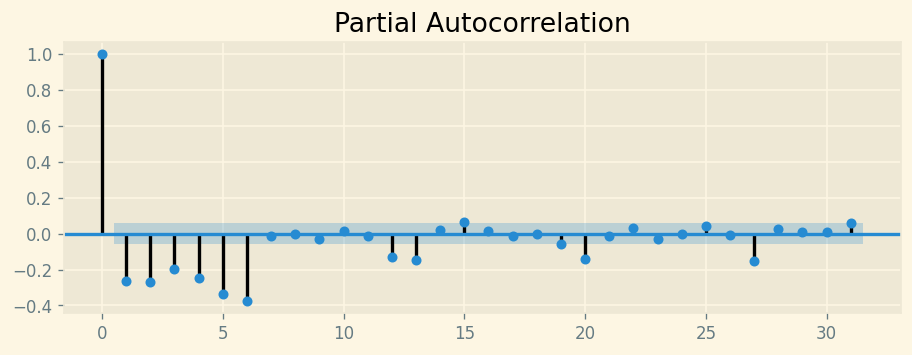

In [388]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

plt.figure(figsize = (15,5))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(diario_est.cantidad_pasos)
plt.show()

De a acuerdo a la gráfica p=6

### Moving Average Model

<Figure size 1800x600 with 0 Axes>

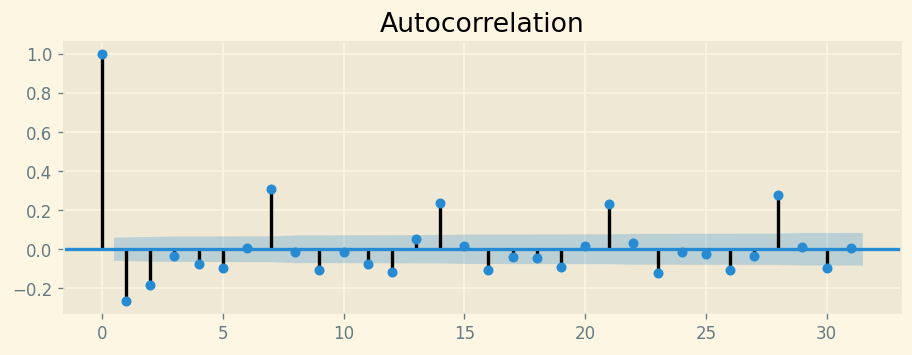

In [389]:
plt.figure(figsize = (15,5))
plot_acf(diario_est.cantidad_pasos)
plt.show()

De a acuerdo a la gráfica q=2

In [390]:
model_arima = sm.tsa.arima.ARIMA(diario.cantidad_pasos, order=(6,1,2))
# statsmodels.tsa.arima_model
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         cantidad_pasos   No. Observations:                 1095
Model:                 ARIMA(6, 1, 2)   Log Likelihood              -11128.567
Date:                Wed, 08 Jun 2022   AIC                          22275.133
Time:                        06:21:18   BIC                          22320.112
Sample:                    01-01-2017   HQIC                         22292.153
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5889      0.100     -5.864      0.000      -0.786      -0.392
ar.L2         -0.6201      0.049    -12.669      0.000      -0.716      -0.524
ar.L3         -0.5670      0.041    -13.995      0.0

Los valores de p son mayores a 0.05, lo cual habla de su poca relevancia para el modelo

In [391]:
# ARIMA(p,d,q)
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(diario.cantidad_pasos, order=(6,1,0))
model_arima_fit = model_arima.fit( )
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:       D.cantidad_pasos   No. Observations:                 1094
Model:                 ARIMA(6, 1, 0)   Log Likelihood              -11114.852
Method:                       css-mle   S.D. of innovations           6247.087
Date:                Wed, 08 Jun 2022   AIC                          22245.704
Time:                        06:21:19   BIC                          22285.684
Sample:                    01-02-2017   HQIC                         22260.833
                         - 12-31-2019                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -15.9997     41.880     -0.382      0.702     -98.082      66.083
ar.L1.D.cantidad_pasos    -0.6640      0.028    -23.735      0.000      -0.719      -0.609
ar.L

En este caso el IAC de 22272.839 es levemente menor que e modelo anterior (22275.133), por lo que tomamos este modelo como Benchmark.

_diario**Ajustamos Benchmark con train**

In [392]:
model_benchmark = ARIMA(train_diario.cantidad_pasos, order=(6,1,2))
model_benchmark_fit = model_benchmark.fit()##disp=0)
fc = model_benchmark_fit.forecast(92)##, alpha=0.05)
#statsmodels.tsa.arima.model.ARIMAResults.forecast

**Evaluamos sobre test**

In [393]:
res_bench =  evaluar_modelo(fc[0], test_diario.cantidad_pasos, "Benchmark(diario)")
res_bench

Modelo         RMSE
0  Benchmark(diario)  6073.494758

Tomemos este valor de RMSE como punto de partida: 6073 pasos diarios

In [394]:
# predicciones_diario = pd.Series(data=fc)
# predicciones_diario

In [395]:
# test

In [396]:
# plot_modelo(train.cantidad_pasos, test.cantidad_pasos, predicciones_diario)

## AutoArima

### Auto Arima (Diario)

In [397]:
modelAA_diario = auto_arima(diario.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      n_jobs=-1)
print(modelAA_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22402.289, Time=3.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22826.598, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22755.192, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22492.342, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22824.599, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22404.037, Time=2.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22387.337, Time=2.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22385.356, Time=1.73 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22388.283, Time=2.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=22385.084, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22491.200, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=22387.065, Time=1.00 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=22387.955, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0]  

In [398]:
# Best model:  ARIMA(0,0,2)(1,1,1)[7]
modelAA_diario.fit(train_diario.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AA_diario = modelAA_diario.predict(n_periods=92, return_conf_int=False)
predicciones_AA_diario = pd.Series(data=pred_AA_diario, index=test_diario.cantidad_pasos.index)
# predicciones_AA_diario.head()

In [399]:
autoarima_diario_res = evaluar_modelo(predicciones_AA_diario, test_diario.cantidad_pasos, "AutoArima-S Diario")
autoarima_diario_res

Modelo         RMSE
0  AutoArima-S Diario  5591.569048

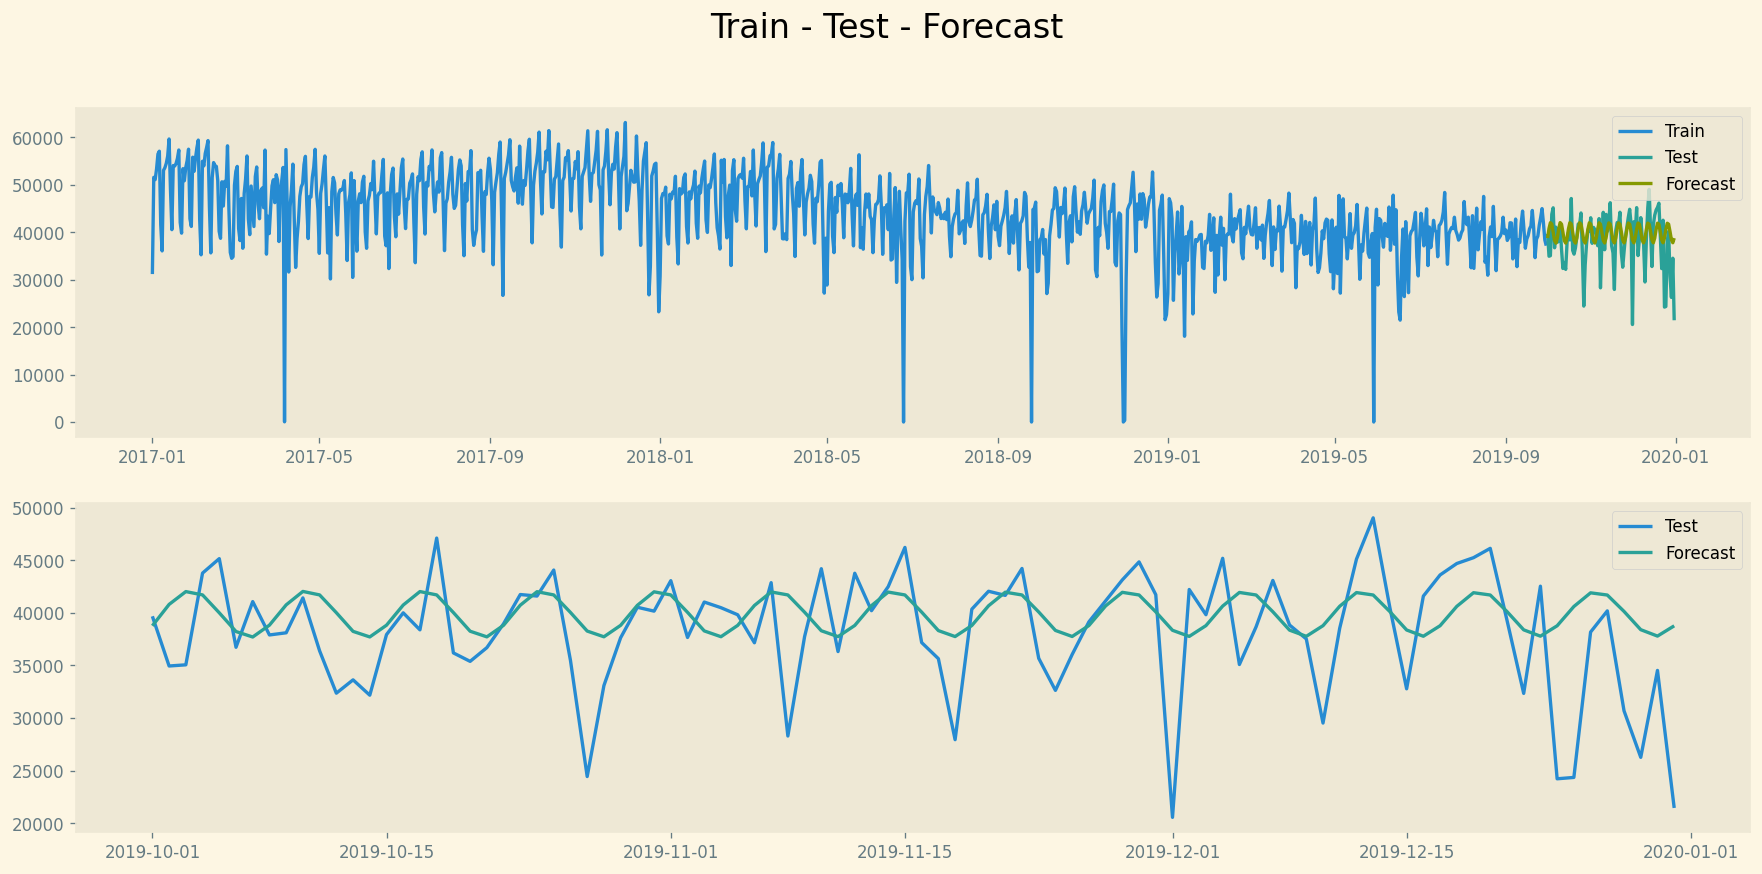

In [400]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AA_diario)

### Sarimax (Diario)

Agreguemos temporalidad diaria para evaluar el autoarima

In [401]:
modelAS_diario = auto_arima(diario.cantidad_pasos, start_p=0, start_q=0,
                      max_p=10, max_q=10  , max_d=2,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      start_Q=0,
                      D=1,
                      m=7, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)
print(modelAS_diario.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=22530.726, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=22300.651, Time=1.73 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=22062.382, Time=2.86 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=22529.005, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=22487.675, Time=0.18 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=22123.762, Time=1.85 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=22131.719, Time=1.58 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=22322.768, Time=0.54 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=22132.703, Time=2.94 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=22194.839, Time=1.69 sec
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=22039.878, Time=4.14 sec
 ARIMA(0,0,2)(0,1,0)[7] intercept   : AIC=22489.650, Time=0.26 sec
 ARIMA(0,0,2)(1,1,1)[7] intercept   : AIC=22030.301, Time=5.36 sec
 ARIMA(0,0,2)(1,1,0)[7] i

In [402]:
# Best model:  ARIMA(0,0,2)(1,1,1)[7] 
# SARIMAX(0, 0, 2)x(1, 1, [1], 7)
modelAS_diario.fit(train_diario.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AS_diario = modelAS_diario.predict(n_periods=92)
predicciones_AS_diario = pd.Series(data=pred_AS_diario, index=test_diario.cantidad_pasos.index)
# predicciones_AS_diario.head()

In [403]:
autosarimax_diario_res = evaluar_modelo(predicciones_AS_diario, test_diario.cantidad_pasos, "AutoSarimax Diario")
autosarimax_diario_res

Modelo        RMSE
0  AutoSarimax Diario  5334.50636

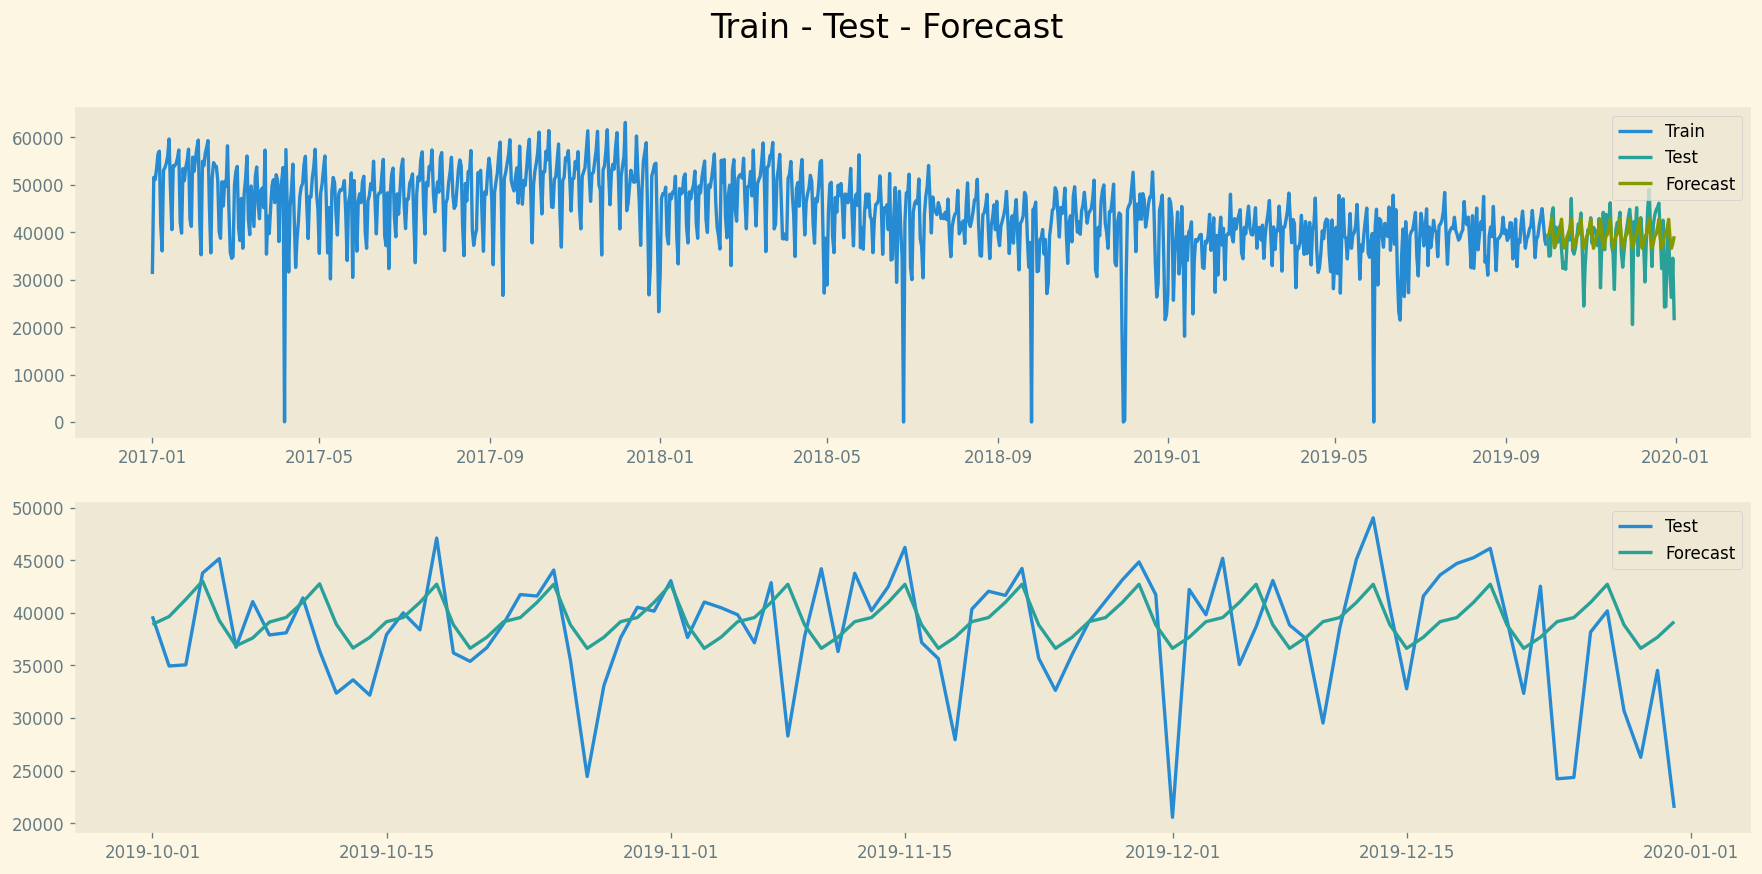

In [404]:
plot_modelo(train_diario.cantidad_pasos, test_diario.cantidad_pasos, predicciones_AS_diario)

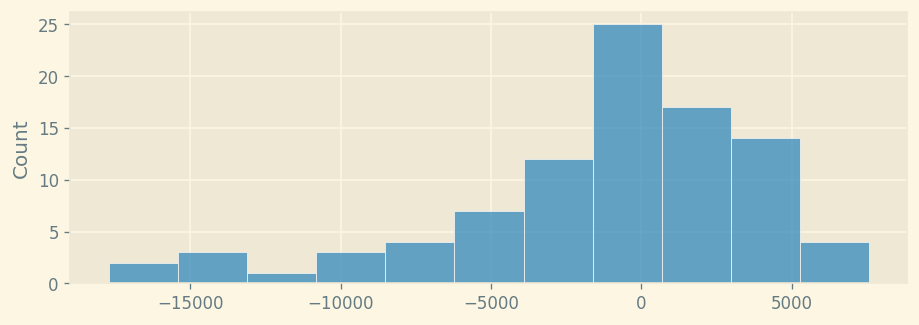

In [405]:
sns.histplot(data = test_diario.cantidad_pasos - predicciones_AS_diario, 
                 label = "Error")

### AutoArima (Semanal)

In [406]:
modelAA_semanal = auto_arima(semanal.cantidad_pasos, start_p=1, start_q=1,
                      max_p=10, max_q=10  ,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      n_jobs=-1)
print(modelAA_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3576.640, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3576.907, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3574.768, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3575.557, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3575.067, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3575.028, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3577.699, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3572.761, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3572.836, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3570.360, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3573.225, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3572.432, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3573.359, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3573.802, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]          

In [407]:
# Best model:  ARIMA(1,1,0)(0,0,0)[0] 

modelAA_semanal.fit(train_semanal.cantidad_pasos)
# train_semanal.set_index('fecha', inplace=True)
# test_semanal.set_index('fecha', inplace=True)
pred_AA_semanal = modelAA_semanal.predict(n_periods=13, return_conf_int=False)
predicciones_AA_semanal = pd.Series(data=pred_AA_semanal, index=test_semanal.cantidad_pasos.index)
predicciones_AA_semanal.head()

fecha
2019-10-06    285396.963003
2019-10-13    283990.055854
2019-10-20    283078.331306
2019-10-27    282487.502228
2019-11-03    282104.624528
dtype: float64

In [408]:
autoarima_semanal_res = evaluar_modelo(predicciones_AA_semanal, test_semanal.cantidad_pasos, "AutoArima Semanal")
autoarima_semanal_res

Modelo          RMSE
0  AutoArima Semanal  20185.213101

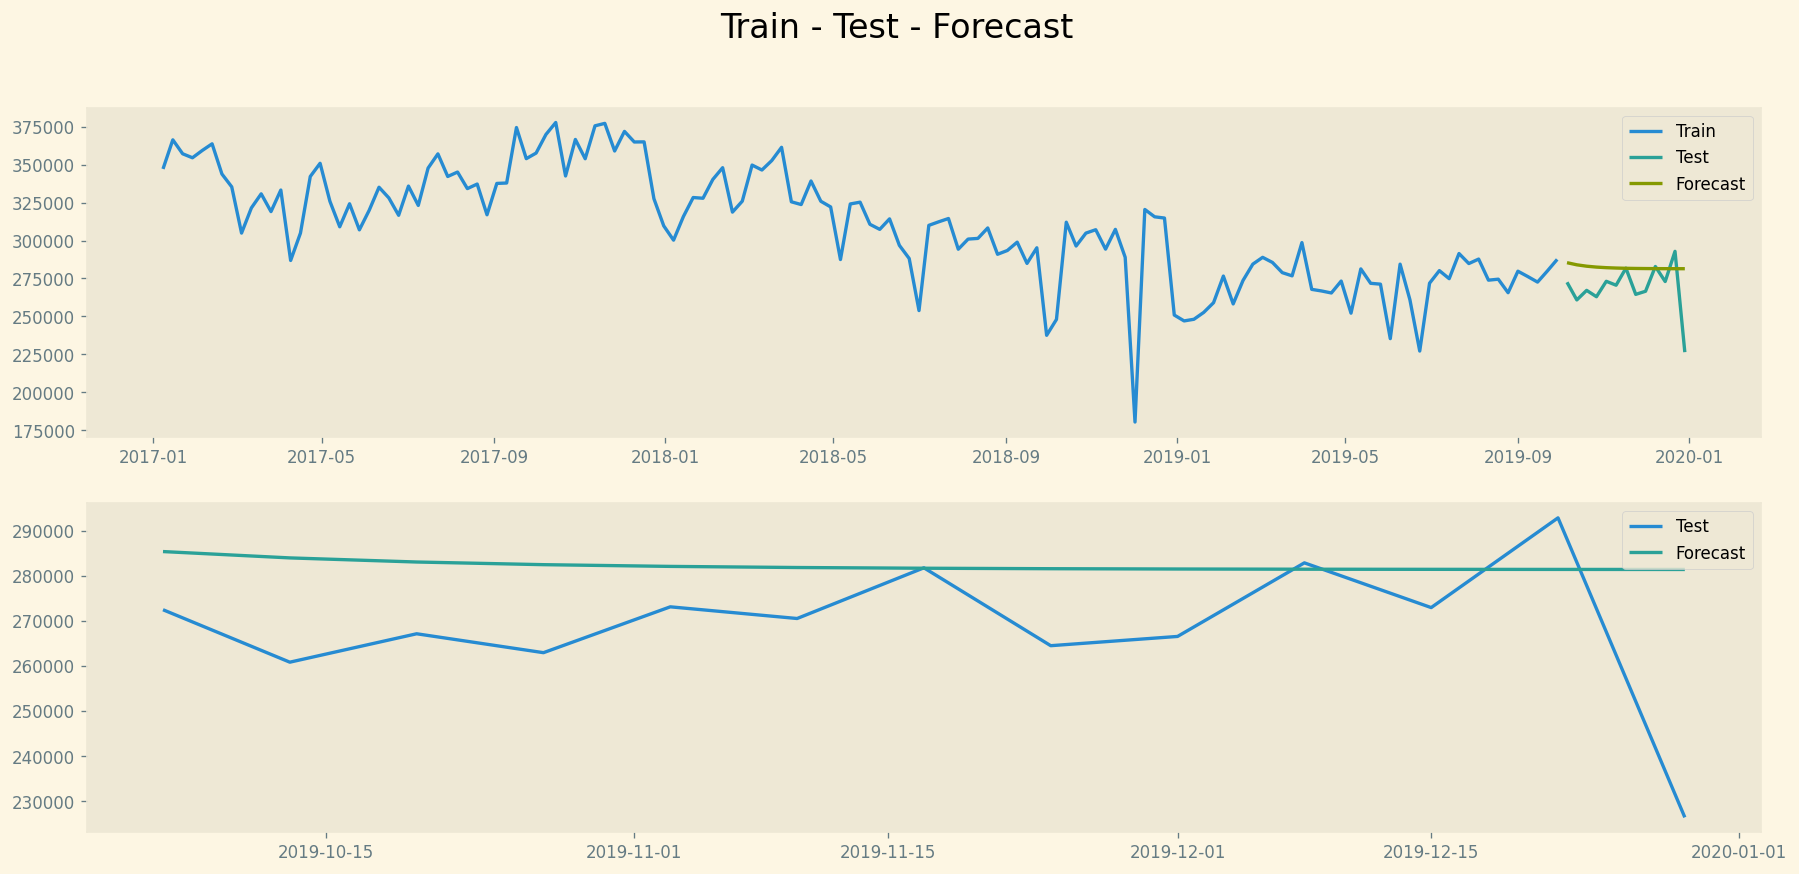

In [409]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AA_semanal)

### Sarimax (Semanal)

In [410]:
modelAS_semanal = auto_arima(semanal.cantidad_pasos, start_p=0, start_q=0,
                      max_p=10, max_q=10  , max_d=2,
                      seasonal=True, # poner si la serie es estacional
                      start_P=0, 
                      start_Q=0,
                      D=1,
                      m=12, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True,
                      n_jobs=-1)
print(modelAS_semanal.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3408.933, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3384.394, Time=0.26 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3385.605, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3412.284, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3399.515, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3385.657, Time=0.59 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=3386.022, Time=0.45 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=3386.176, Time=0.33 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=3386.520, Time=1.27 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=3401.853, Time=0.31 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3385.264, Time=0.37 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=3385.365, Time=0.43 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=3384.213, Time=0.19 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=3397.105, Time=0.07 sec
 ARIMA(0,0,1)(2,1,0

In [411]:
# Best model:  ARIMA(4,0,0)(2,1,2)[12]
# SARIMAX(4, 0, 0)x(2, 1, [1, 2], 12)
modelAS_semanal.fit(train_semanal.cantidad_pasos)
# train_diario.set_index('fecha', inplace=True)
# test_diario.set_index('fecha', inplace=True)
pred_AS_semanal = modelAS_semanal.predict(n_periods=13)
predicciones_AS_semanal = pd.Series(data=pred_AS_semanal, index=test_semanal.cantidad_pasos.index)
# predicciones_AS_diario.head()

In [412]:
autosarimax_semanal_res = evaluar_modelo(predicciones_AS_semanal, test_semanal.cantidad_pasos, "AutoSarimax semanal")
autosarimax_semanal_res

Modelo          RMSE
0  AutoSarimax semanal  19558.624622

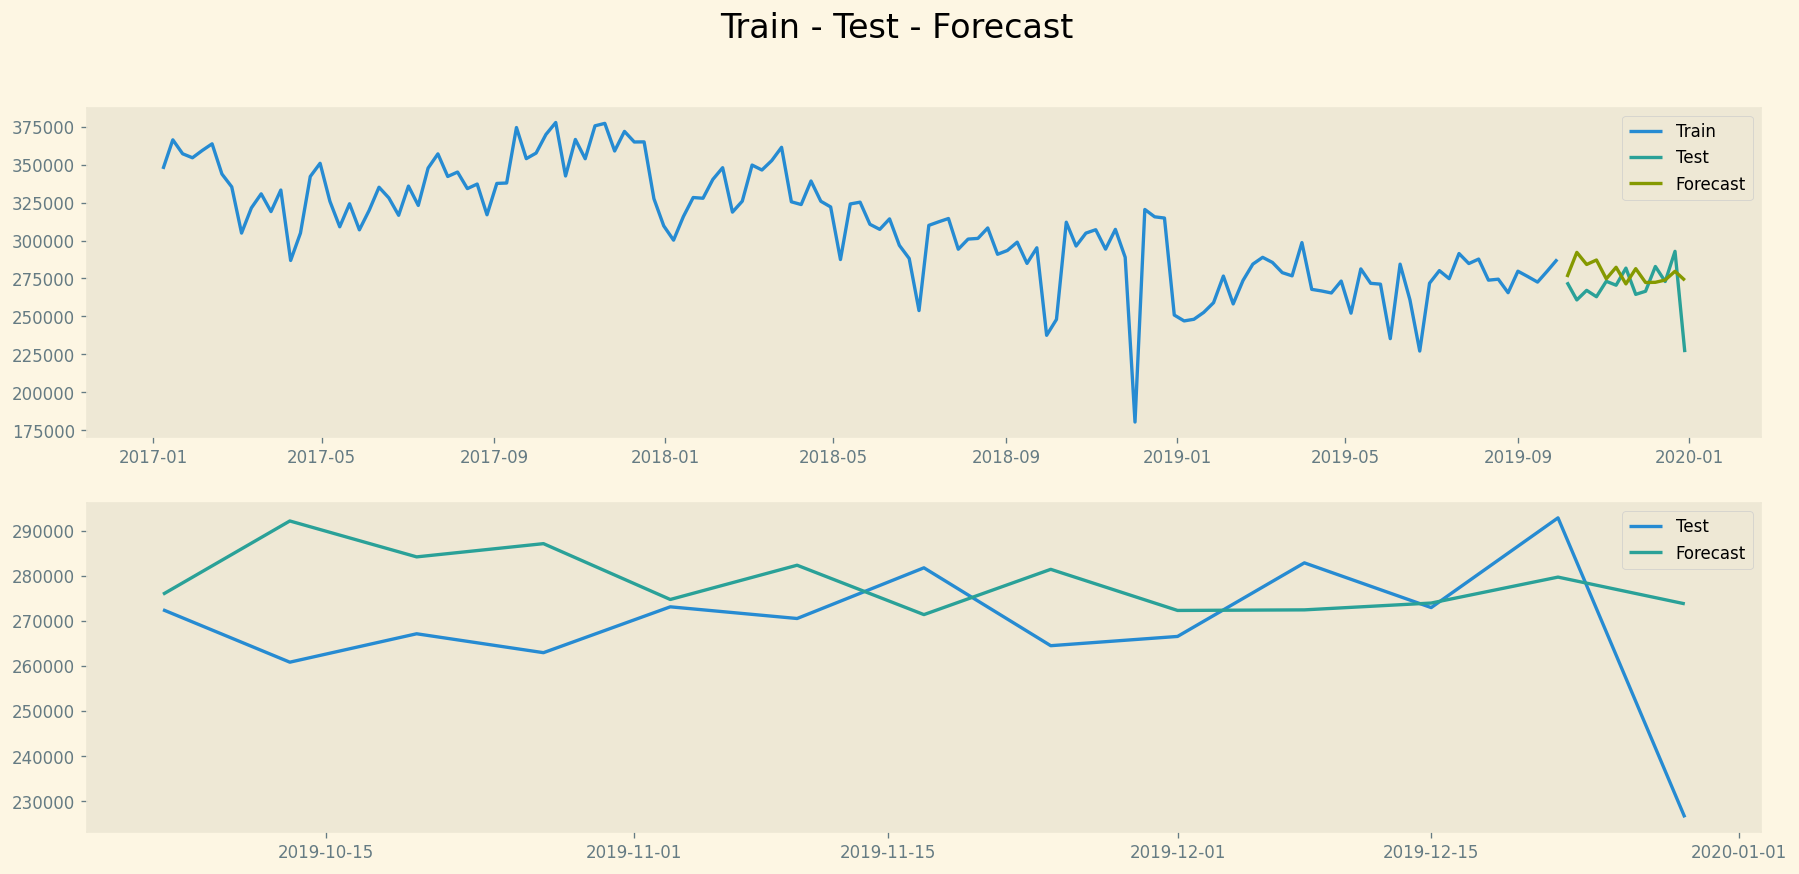

In [413]:
plot_modelo(train_semanal.cantidad_pasos, test_semanal.cantidad_pasos, predicciones_AS_semanal)

In [414]:
pd.concat([res_bench,
                        autoarima_diario_res, autosarimax_diario_res, 
                        autoarima_semanal_res, autosarimax_semanal_res
                         ])
# res_finales.reset_index(drop=True)

Modelo          RMSE
0    Benchmark(diario)   6073.494758
0   AutoArima-S Diario   5591.569048
0   AutoSarimax Diario   5334.506360
0    AutoArima Semanal  20185.213101
0  AutoSarimax semanal  19558.624622

In [415]:
autoarima_diario_res

Modelo         RMSE
0  AutoArima-S Diario  5591.569048

## Prophet

### Prophet Diario

In [416]:
diario.reset_index("fecha",inplace=True)



prophet_diario = pd.DataFrame({'ds':diario.fecha, 'y':diario.cantidad_pasos})


diario.set_index("fecha", inplace=True)


In [417]:
separacion = '2019-10-01'
prophet_fore = prophet_diario.loc[prophet_diario.ds < separacion]
prophet_fore

ds      y
0    2017-01-01  31183
1    2017-01-02  51568
2    2017-01-03  51093
3    2017-01-04  53332
4    2017-01-05  56486
...         ...    ...
998  2019-09-26  43110
999  2019-09-27  44985
1000 2019-09-28  41925
1001 2019-09-29  38348
1002 2019-09-30  37170

[1003 rows x 2 columns]

In [418]:
diario_datos_test = prophet_diario.loc[prophet_diario.ds >= separacion]
diario_datos_test

ds      y
1003 2019-10-01  39669
1004 2019-10-02  34943
1005 2019-10-03  35054
1006 2019-10-04  43775
1007 2019-10-05  45150
...         ...    ...
1090 2019-12-27  40182
1091 2019-12-28  30681
1092 2019-12-29  26259
1093 2019-12-30  34523
1094 2019-12-31  21447

[92 rows x 2 columns]

In [419]:
prophet_diario_model = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_diario_model.fit(prophet_fore)
pred_prophet = prophet_diario_model.make_future_dataframe(periods=92, freq="D")
forecast = prophet_diario_model.predict(pred_prophet)

In [420]:
forecast.tail(3)

ds        trend    yhat_lower    yhat_upper  trend_lower  \
1092 2019-12-29  8997.358298  20485.879130  41353.328028  1991.452547   
1093 2019-12-30  9001.465471  25803.313846  46986.854303  1840.135631   
1094 2019-12-31  9005.572645  27261.041630  48277.839209  1708.737161   

       trend_upper  additive_terms  additive_terms_lower  \
1092  16363.839460    22346.130844          22346.130844   
1093  16505.219738    27894.933581          27894.933581   
1094  16612.889811    28828.507495          28828.507495   

      additive_terms_upper         daily  ...       weekly  weekly_lower  \
1092          22346.130844  31374.443268  ... -7039.610245  -7039.610245   
1093          27894.933581  31374.443268  ... -1112.874005  -1112.874005   
1094          28828.507495  31374.443268  ...   175.011360    175.011360   

      weekly_upper       yearly  yearly_lower  yearly_upper  \
1092  -7039.610245 -1988.702179  -1988.702179  -1988.702179   
1093  -1112.874005 -2366.635682  -2366.635682  -2366.635682   
1094    175.011360 -2720.947133  -2720.947133  -2720.947133   

      multiplicative_terms  multiplicative_terms_lower  \
1092                   0.0                         0.0   
1093                   0.0                         0.0   
1094                   0.0                         0.0   

      multiplicative_terms_upper          yhat  
1092                         0.0  31343.489142  
1093                         0.0  36896.399052  
1094                         0.0  37834.080140  

[3 rows x 22 columns]

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

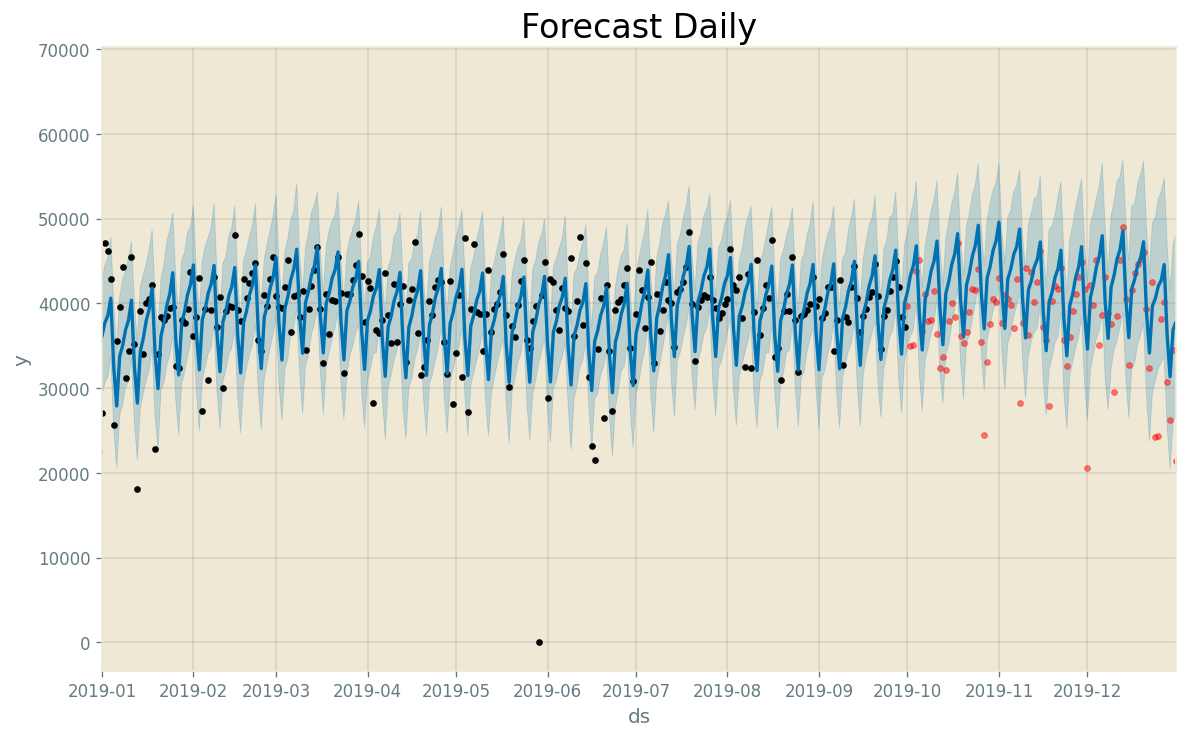

In [421]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast Daily', fontsize=20)

In [422]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >= separacion) & (forecast.ds <= "2019-12-31")]
y_true = diario_datos_test[['ds', 'y']]


res_prophet_diario = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario")
res_prophet_diario

Modelo         RMSE
0  Prophet Diario  6415.439744

### Optimizando

In [423]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    # 'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    # 'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.001,0.01,0.1, 0.5, 0.7],
    'seasonality_prior_scale': [0.001, 0.005,0.01,0.05,0.1,0.5,1,5,10],


}



# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=True).fit(prophet_fore)  # Fit model with given params
    df_cv = cross_validation(m, horizon='92 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dbfd607d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dbfe92110>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dbfe5d150>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-09 00:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0d

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                    0.001  12684.496196
1                     0.001                    0.005  10802.552508
2                     0.001                    0.010  10447.166534
3                     0.001                    0.050  12721.929782
4                     0.001                    0.100  11642.007484
5                     0.001                    0.500  11696.292643
6                     0.001                    1.000  12106.182188
7                     0.001                    5.000  14168.574711
8                     0.001                   10.000  14159.655114
9                     0.010                    0.001   7589.076268
10                    0.010                    0.005   7129.673641
11                    0.010                    0.010   7363.422414
12                    0.010                    0.050   7835.824470
13                    0.010                    0.100   7772.35

In [424]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.005}


In [425]:
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.03}
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.005}

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.005}

In [426]:
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020}

In [427]:
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_fore)
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=92)
forecast = prophet_diario_model_op.predict(pred_prophet)

Text(0.5, 1.0, 'Forecast Daily')

<Figure size 1440x360 with 0 Axes>

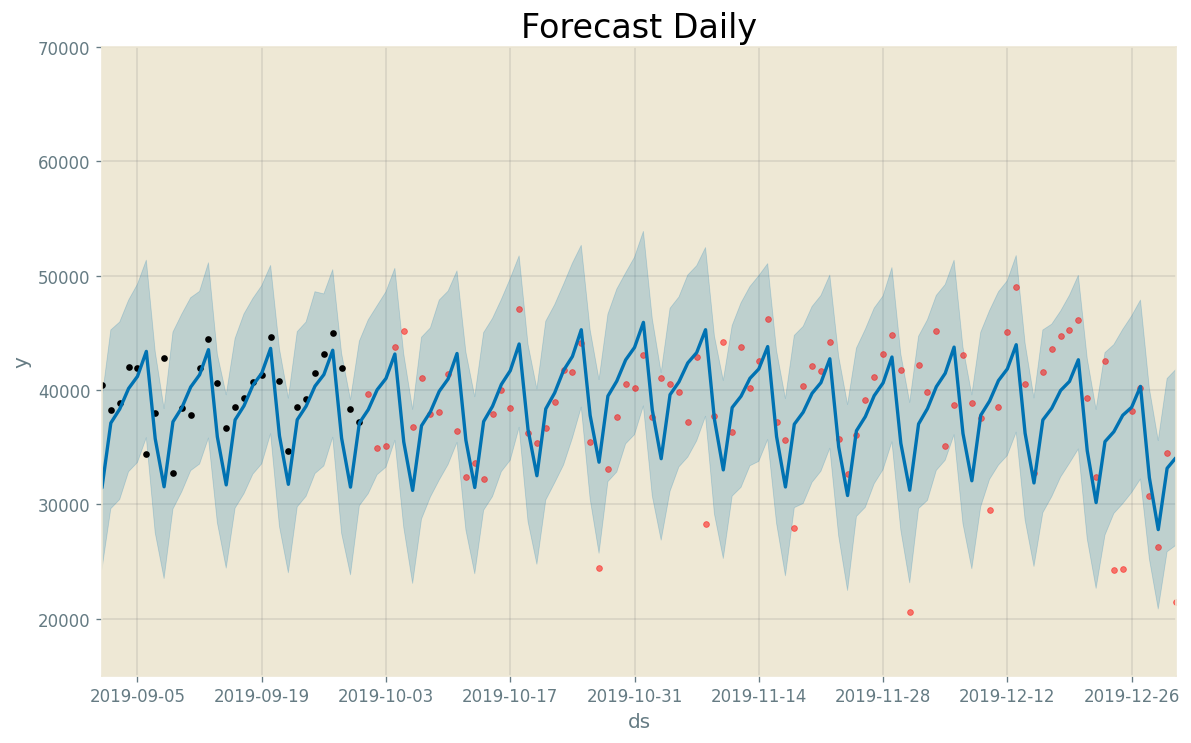

In [428]:
plt.figure(figsize=(12,3))
fig1 = prophet_diario_model_op.plot(forecast)
plt.scatter(diario_datos_test.ds, diario_datos_test.y, color= "red", s=12 ,alpha=0.5)
dates=np.array(["2019-09-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.ylim(15000, 70000)
plt.title('Forecast Daily', fontsize=20)

In [429]:
y_pred = forecast[['ds', 'yhat']].loc[(forecast.ds >= separacion) & (forecast.ds < "2020-01-05")]
y_true = diario_datos_test[['ds', 'y']]

#### Mejor Prophet

In [430]:
res_prophet_diario_opt = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Diario CV/HP")
res_prophet_diario_opt

Modelo         RMSE
0  Prophet Diario CV/HP  5047.143789

### Prophet Semanal

In [431]:
semanal.reset_index("fecha",inplace=True)

prophet_semanal = pd.DataFrame({'ds':semanal.fecha, 'y':semanal.cantidad_pasos})

semanal.set_index("fecha", inplace=True)

In [432]:
separacion = '2019-10-01'
prophet_fore_semanal = prophet_semanal.loc[prophet_semanal.ds < separacion]
prophet_fore_semanal

semanal_datos_test = prophet_semanal.loc[prophet_semanal.ds >= separacion]
len(semanal_datos_test)

13

In [433]:
semanal_datos_test

ds       y
143 2019-10-06  272483
144 2019-10-13  260840
145 2019-10-20  267147
146 2019-10-27  262950
147 2019-11-03  273129
148 2019-11-10  270536
149 2019-11-17  281790
150 2019-11-24  264500
151 2019-12-01  266555
152 2019-12-08  282891
153 2019-12-15  272960
154 2019-12-22  292881
155 2019-12-29  226390

In [434]:
prophet_semanal = Prophet(daily_seasonality=True,changepoint_prior_scale=5)
prophet_semanal.fit(prophet_fore_semanal)
pred_prophet_semanal = prophet_semanal.make_future_dataframe(periods=13, freq="W")
forecast_semanal = prophet_semanal.predict(pred_prophet_semanal)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

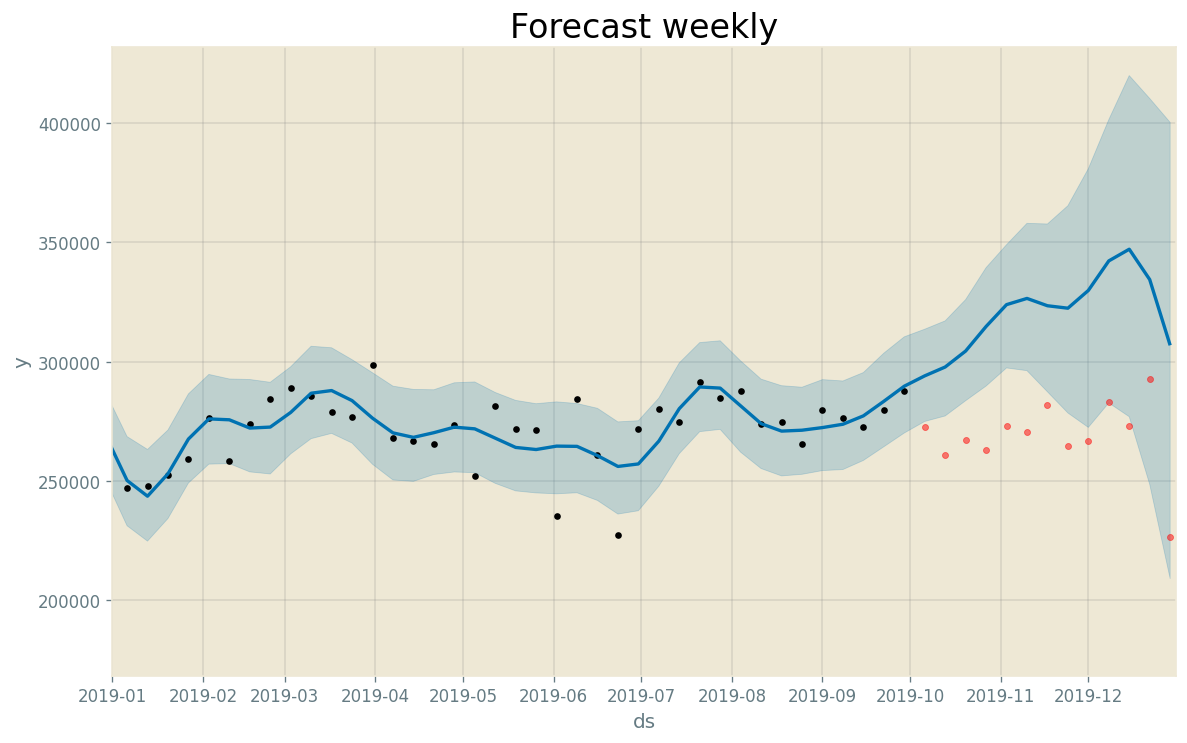

In [435]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal.plot(forecast_semanal)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=13 ,alpha=0.5)
dates=np.array(["2019-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

In [436]:
y_pred = forecast_semanal[['ds', 'yhat']].loc[(forecast_semanal.ds >= separacion) & (forecast_semanal.ds <= "2019-12-31")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_semanal = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal")
res_prophet_semanal

Modelo          RMSE
0  Prophet Semanal  54022.453477

In [437]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    # 'changepoint_prior_scale': [0.001,0.01,0.1, 0.5, 0.7],
    # 'seasonality_prior_scale': [0.001, 0.005,0.01,0.05,0.1,0.5,1,5,10],


}



# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=True, weekly_seasonality=True).fit(prophet_fore_semanal)  # Fit model with given params
    df_cv = cross_validation(m, horizon='13 w', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dbb2be210>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dbfae3890>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dc2a12ad0>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f0dbb5c25d0>
INFO:fbprophet:Making 12 forecasts with cutoffs between 2018-02-14 12:00:00 and 2019-06-30 00:00:00
INFO:fbprophet:Applying in parallel with

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  34012.606262
1                     0.001                     0.10  38557.046502
2                     0.001                     1.00  38464.724123
3                     0.001                    10.00  38338.290240
4                     0.010                     0.01  33647.333923
5                     0.010                     0.10  38468.439174
6                     0.010                     1.00  38635.629933
7                     0.010                    10.00  38611.380905
8                     0.100                     0.01  30069.230862
9                     0.100                     0.10  37684.997375
10                    0.100                     1.00  39078.839787
11                    0.100                    10.00  40576.688613
12                    0.500                     0.01  29371.705661
13                    0.500                     0.10  39060.74

In [438]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [439]:
best_params = {'changepoint_prior_scale': 0.07, 'seasonality_prior_scale': 0.005}

In [440]:
prophet_semanal_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_semanal_model_op.fit(prophet_fore_semanal)
pred_prophet_semanal_op = prophet_semanal_model_op.make_future_dataframe(periods=13, freq="W" )
forecast_semanal_op = prophet_semanal_model_op.predict(pred_prophet_semanal_op)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5, 1.0, 'Forecast weekly')

<Figure size 1440x360 with 0 Axes>

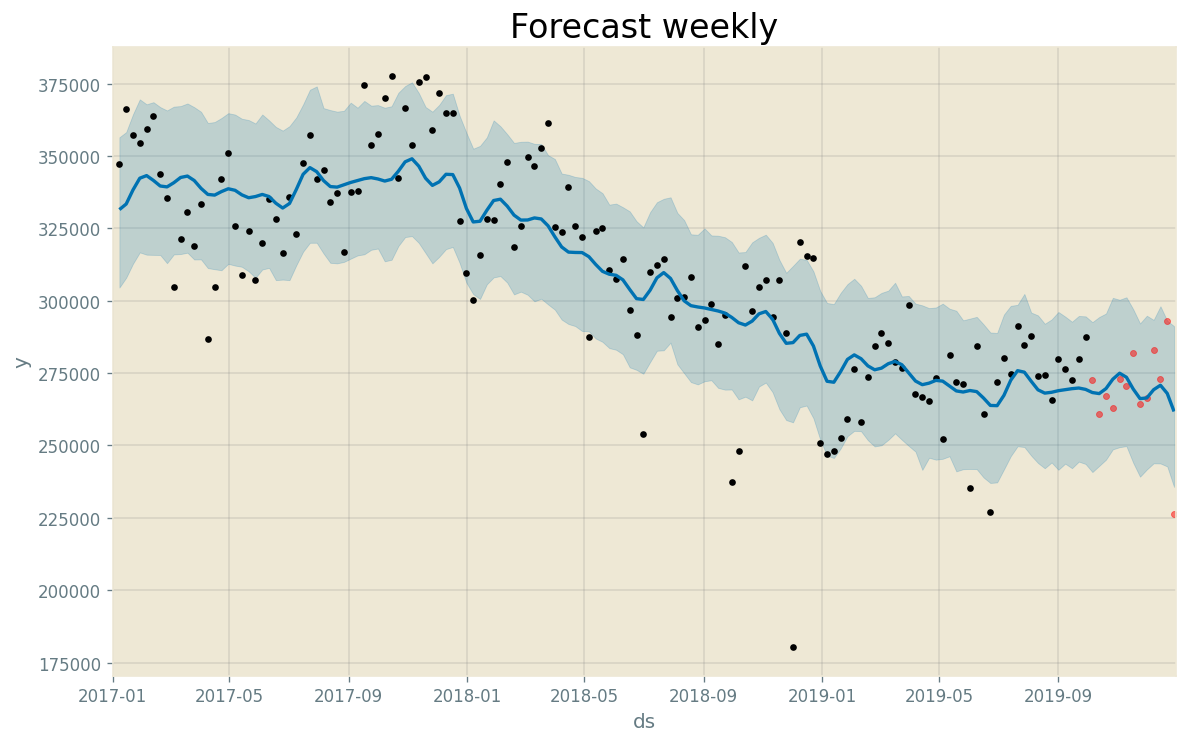

In [441]:
plt.figure(figsize=(12,3))
fig1 = prophet_semanal.plot(forecast_semanal_op)
plt.scatter(semanal_datos_test.ds, semanal_datos_test.y, color= "red", s=13 ,alpha=0.5)
dates=np.array(["2017-01-01","2019-12-31"], dtype='datetime64[ns]')
plt.xlim(dates)
plt.title('Forecast weekly', fontsize=20)

In [442]:
y_pred = forecast_semanal_op[['ds', 'yhat']].loc[(forecast_semanal_op.ds >= separacion) & (forecast_semanal_op.ds <= "2019-12-31")]
y_true = semanal_datos_test[['ds', 'y']]


res_prophet_semanal_op = evaluar_modelo(y_pred['yhat'],y_true['y'],"Prophet Semanal CV/HP")
res_prophet_semanal_op

Modelo          RMSE
0  Prophet Semanal CV/HP  13586.183137

In [443]:
pd.concat([res_bench,
                        autoarima_diario_res, autosarimax_diario_res, 
                        res_prophet_diario, res_prophet_diario_opt,
                        
                        autoarima_semanal_res, autosarimax_semanal_res,
                        res_prophet_semanal, res_prophet_semanal_op
                         ])

Modelo          RMSE
0      Benchmark(diario)   6073.494758
0     AutoArima-S Diario   5591.569048
0     AutoSarimax Diario   5334.506360
0         Prophet Diario   6415.439744
0   Prophet Diario CV/HP   5047.143789
0      AutoArima Semanal  20185.213101
0    AutoSarimax semanal  19558.624622
0        Prophet Semanal  54022.453477
0  Prophet Semanal CV/HP  13586.183137

Las métricas RMSE más destacadas, resultan:

- Modelo Benchmark, RMSE= 6073 pasos diarios,
- AutoSarimax Semanal, RMSE= 19558 pasos diarios, y 
- Prophet Optimizado (), RMSE= 5047 pasos diarios, representando un 16.9% de mejora en relación al modelo Benchmark.

# Investigación

## Usar modelo generado en el año 2020

Preparamos la data 2020 para aplicarle Prophet Optimizado

In [444]:
#Importamos
data_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sprint Project 3/flujo-vehicular-2020.csv')

# #Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2020.estacion=='ILLIA', data_2020.forma_pago == 'Efectivo')
dataset2020 = data_2020[mask]

# # #Quitamos las columnas que no vamos a utilizar
dataset2020 = dataset2020[['fecha','cantidad_pasos','hora_fin']]

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset2020['fecha2'] = pd.to_datetime(dataset2020.fecha) + pd.to_timedelta(dataset2020.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2020.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset2020.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset2020.sort_values('fecha', inplace = True)
dataset2020.reset_index(drop=True, inplace = True)

#Resampleamos
diario2020 = dataset2020.resample('D', on = 'fecha').sum()
diario2020.reset_index("fecha",inplace=True)
prophet_diario2020 = pd.DataFrame({'ds':diario2020.fecha, 'y':diario2020.cantidad_pasos})

prophet_diario2020

ds        y
0   2020-01-01  21395.0
1   2020-01-02  33722.0
2   2020-01-03  37067.0
3   2020-01-04  30627.0
4   2020-01-05  27812.0
..         ...      ...
361 2020-12-27   8434.0
362 2020-12-28  10311.0
363 2020-12-29  12036.0
364 2020-12-30  12527.0
365 2020-12-31   6553.0

[366 rows x 2 columns]

Recordamos el modelo

In [445]:
#Modelo
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020} #Da 5050
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_fore)

Realizamos predicción sobre 2020 y comparamos:

In [446]:
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=365)
forecast = prophet_diario_model_op.predict(prophet_diario2020)
y_pred2020 = forecast[['ds', 'yhat']]
y_true2020 = prophet_diario2020

res_prophet_diario_opt2020 = evaluar_modelo(y_pred2020['yhat'],y_true2020['y'],"Prophet Sobre 2020")
res_prophet_diario_opt2020

Modelo          RMSE
0  Prophet Sobre 2020  23327.135059

In [447]:
prophet_diario2020

ds        y
0   2020-01-01  21395.0
1   2020-01-02  33722.0
2   2020-01-03  37067.0
3   2020-01-04  30627.0
4   2020-01-05  27812.0
..         ...      ...
361 2020-12-27   8434.0
362 2020-12-28  10311.0
363 2020-12-29  12036.0
364 2020-12-30  12527.0
365 2020-12-31   6553.0

[366 rows x 2 columns]

Tal como arroja el resultado de RMSE=23327 pasos diarios, el año 2020 presenta un patrón de pasos notablemente diferente a los aportados por los otros datasets evaluados. Se infiere que un elemento disruptivo como la pandemia, acompañada de una cuarentena estricta puede estar gobernando los datos.

## Se agregan datos de 2016 y se evalúa el modelo

A continuación los datos del año 2016

In [448]:
#Importamos
datax_2016 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sprint Project 3/flujo-vehicular-2016.csv')
data_2016 = pd.concat([data_2019, data_2018, data_2017, datax_2016])
# data_2016 = pd.concat([data_2019, data_2018, data_2017])

# #Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(data_2016.estacion=='Illia', data_2016.forma_pago == 'EFECTIVO')
dataset2016 = data_2016[mask]

# # #Quitamos las columnas que no vamos a utilizar
dataset2016 = dataset2016[['fecha','cantidad_pasos','hora_fin']]

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset2016['fecha2'] = pd.to_datetime(dataset2016.fecha) + pd.to_timedelta(dataset2016.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset2016.drop(columns=['fecha','hora_fin'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset2016.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset2016.sort_values('fecha', inplace = True)
dataset2016.reset_index(drop=True, inplace = True)

# #Resampleamos
diario2016 = dataset2016.resample('D', on = 'fecha').sum()
diario2016.reset_index("fecha",inplace=True)
prophet_diario2016 = pd.DataFrame({'ds':diario2016.fecha, 'y':diario2016.cantidad_pasos})

prophet_diario2016_train = prophet_diario2016.iloc[:-92,:]
print('Train', prophet_diario2016_train.shape)
prophet_diario2016_test = prophet_diario2016.iloc[-92:,:]
print('Test', prophet_diario2016_test.shape)

Train (1369, 2)
Test (92, 2)


Entrenemos el modelo con la nueva data

In [449]:
#Modelo
best_params = {'changepoint_prior_scale': 0.007, 'seasonality_prior_scale': 0.020} #Da 5050
prophet_diario_model_op = Prophet(**best_params, daily_seasonality=True)
prophet_diario_model_op.fit(prophet_diario2016_train)

Evaluemos RMSE sobre los mismos tres meses

In [450]:
pred_prophet = prophet_diario_model_op.make_future_dataframe(periods=92)
forecast = prophet_diario_model_op.predict(prophet_diario2016_test)
y_pred2016 = forecast[['ds', 'yhat']]
y_true2016 = diario_datos_test[['ds', 'y']]

res_prophet_diario_opt2016 = evaluar_modelo(y_pred2016['yhat'],y_true2016['y'],"Prophet Sobre con 2016")
res_prophet_diario_opt2016

Modelo         RMSE
0  Prophet Sobre con 2016  5466.582718

El modelo ajustado arroja para el año 2016 una métrica RMSE= 5466 pasos diarios. Representa un aumento de la métrica del 8.3% en relación al desempeño de Prophet Diario (RMSE=5047).

# CONCLUSIONES

El presente trabajo tuvo por objetivo la evaluación y predicción de cantidad de pasos de vehículos por las estaciones con sentido 'Provincia' y 'Centro'.
Los datos fueron tomados de la url: https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-de-peaje-ausa.

Se realizó el análisis exploratorio de datos obligado para el conocimiento de los datos, columnas, valores faltantes, etc.; lo cual permite entender los datos disponibles y evaluar la necesidad de realizar transformaciones, ingeniería de features o escalado, que para el caso no se encontró necesario por tratarse de valores de similar orden de magnitud, desarrollados en serie de tiempo.

Cabe aclarar que no se encontraron nulos en los dataset.

Se observó similar patrón de pasos diarios para las distintas estaciones, sobre todo en los datasets correspondientes a los años 2017 y 2018.

El dataset de año 2019 arroja menores pasos, sobre todo en las estaciones en las que más pasos se registran en los otros periodos, Avellaneda e Illia.

Una vez conocidos los datos de los periodos 2017/18 y '19, se procedió a concatenar los distintos datasets para luego realizar la partición en train/test para pasar a evaluar modelos.

Se evaluó un modelo benchmark, ARIMA de frecuencia diaria el cual arrojó una métrica RMSE= 6073 pasos diarios.

Además, se evaluó un modelo SARIMAX frecuencia semanal que arrojó RMSE= 19558 pasos.

Se evaluaron además modelos Prophet, frecuencia diaria y semanal con optimización de hiperparámetros arrojando RMSE= 5047 Y RMSE= 13586 pasos, respectivamente.

A continuación se transcribe la lista de métrica RMSE para todos los modelos evaluados:

Modelo	RMSE
-	Benchmark(diario)	6073.49
-	AutoArima-S Diario	5591.57
-	AutoSarimax Diario	5334.50
-	Prophet Diario	6415.44
-	Prophet Diario CV/HP	5047.14
-	AutoArima Semanal	20185.21
-	AutoSarimax semanal	19558.62
-	Prophet Semanal	54022.45
-	Prophet Semanal CV/HP	13586.18


De acuerdo a las métricas observadas, el modelo mejor ajustado es Prophet Diario con optimización de hiperparámetros, el cual arrojó RMSE= 5047 pasos.

Adicionalmente, se importaron los datos de pasos correspondientes a los años 2016 y 2020.

Para el caso de año 2020, el modelo mejor ajustado, mencionado, arrojó RMSE= 23327 pasos, lo cual permite inferir una influencia sustancial del periodo de cuarentena estricta dictada durante el desarrollo de la pandemia COVID-19.

En lo que respecta al año 2016 el mismo modelo, Prophet diario con optimización, arrojó RMSE= 5466 pasos valor que se encuentra solo un 8.3% por encima del error calculado para el dataset compuesto por datos de los años 2017/18 y '19.